# Preference Trick - Part 1

In this document we show our first tentative to calculate the preferance matrix of Soft Linkage. 

We start with an image of relevant points taken from the **Jiqing Expressway Dataset** and we show the result of line detection using the **Extended Hough Transform**. In particular we show the correlation of this result to Kmeans cluster technique.

Then we build the preference matrix that we will use for Soft Linkage.


### Our Approach to calculate the Preference Matrix

The main idea of our calculation of the preference matrix is the following:
* Start with DBScan clustering to extract the initial clusters which indicates the presence of a simil-line
* For each point *p* calculate its preference on the cluster *C* in this way:
    - calculate the parabola (**model**) passing through the point of cluster *C*
    - calculate the error of *p* to be considered a point of this cluster *C* as the following:
        * `err = | y_point - parabola(x_point)|`
 


In [1]:
### import libraries
import os
import cv2 as cv2
import numpy as np
import json  as json
import imutils
import math
from matplotlib import pyplot as plt

path_dataset = './dataset/bilboards/'

def iread(img_path, resize_width=None):
    img = cv2.imread(path_dataset + img_path)
    if resize_width is not None:
        img = imutils.resize(img, width=resize_width)
    return img

def iinfo(img):
    print("[IMAGE] height: {} x width: {} x channels: {} - data type: {}".format(
        img.shape[0], 
        img.shape[1], 
        (img.shape[2] if img.ndim > 2 else 0),
        img.dtype))

## Preface - Hough Extended Transform 

We start performing Hough Extended Transform in a frame extracted from  **Jiqing Expressway Dataset**.

Unfortunatly the lanes of the road, that have been tagged with their ground trouth in this dataset, don't show relevant radial distortion, so using them for this experiment it would not be so interesting. 

We decide to take in consideration the electrical wires of the road. Infact these wires in the video are almost lines but when the car is passing through them, they are heavily subject to radial distorted and they are perceved as parabolas due to the barrel effect. 

So we formulate our first assumption:

`The electrical wires shown on the image, are **lines** representation in the radial distorted space.` 

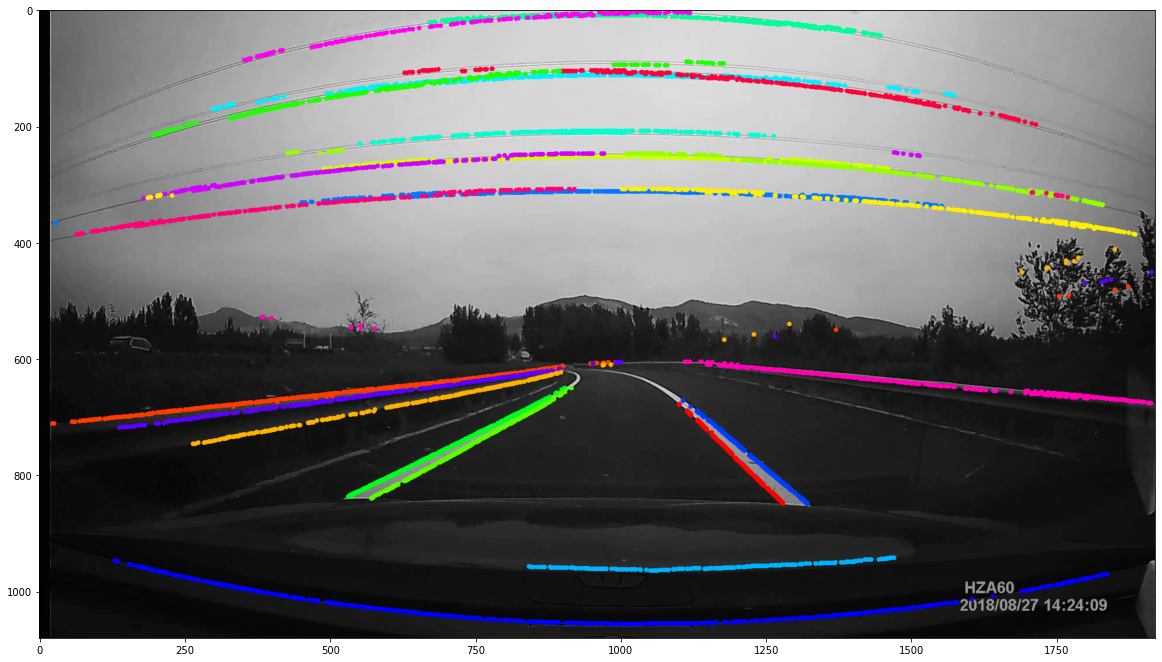

In [2]:
nemesis = iread('dataset_IMG_0249_18.png')
plt.figure(figsize = (20,20))
plt.imshow(nemesis)

### Starting Point - Edges 

To have the same starting point of **The Hough Extendend Transform** we use as input image the edges points extracted by the same algorithm.

Fortunately, the implementation of the **The Hough Extendend Transform** that we are using provides as output an image of the edges.


[IMAGE] height: 1080 x width: 1920 x channels: 0 - data type: uint8


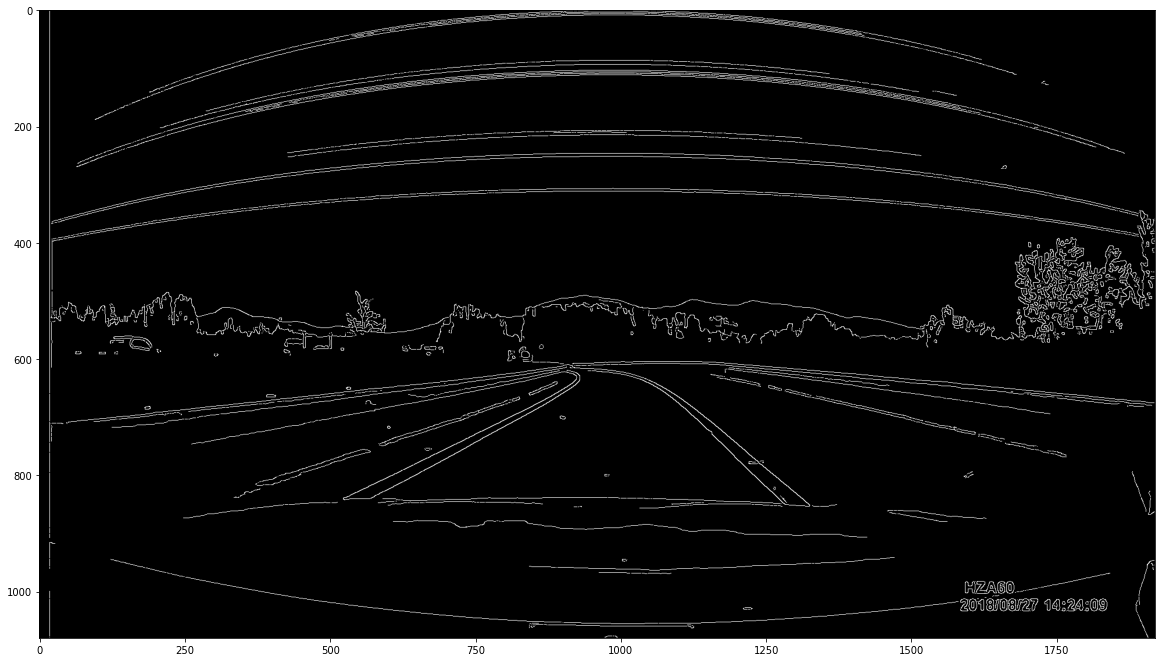

In [3]:
edges_rgb   = iread('dataset_IMG_0249_18_canny.png')
edges_white = cv2.cvtColor(edges_rgb, cv2.COLOR_BGR2GRAY)
edges = cv2.bitwise_not(edges_white)

plt.figure(figsize=(20,20))
plt.imshow(edges, cmap='gray')
iinfo(edges)

### Extract The Region of Interest

From the edges image we crop the roi (region of interest) in which we want to perform our experiments.

In this case, our roi cointains the electrical wires of the road

[IMAGE] height: 420 x width: 1920 x channels: 0 - data type: uint8


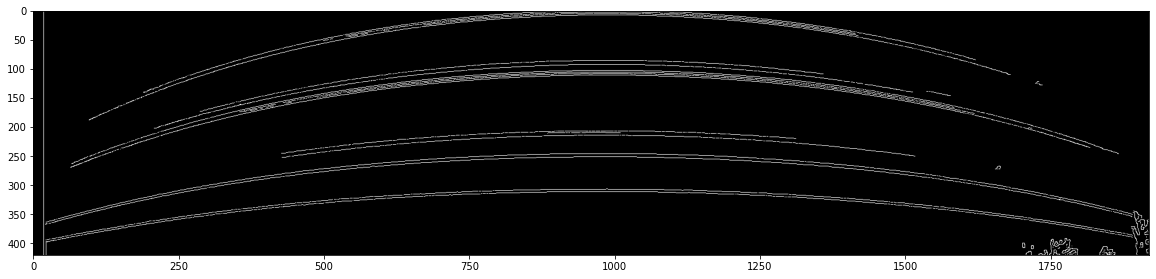

In [4]:
roi=edges[0:420, 0:]
plt.figure(figsize=(20, 20))
plt.imshow(roi, cmap='gray')
iinfo(roi)

## Clustering with KMeans and correlation with Extended Hough Transform

Before starting with preference matrix calculation, we perform KMeans clustering and we show that the result has the same defects that are visible in the Extended Hough Transform.

In this particular approach seems quite difficult to detect fully the parabola curve and it seems that a break in the curve its almost needed.


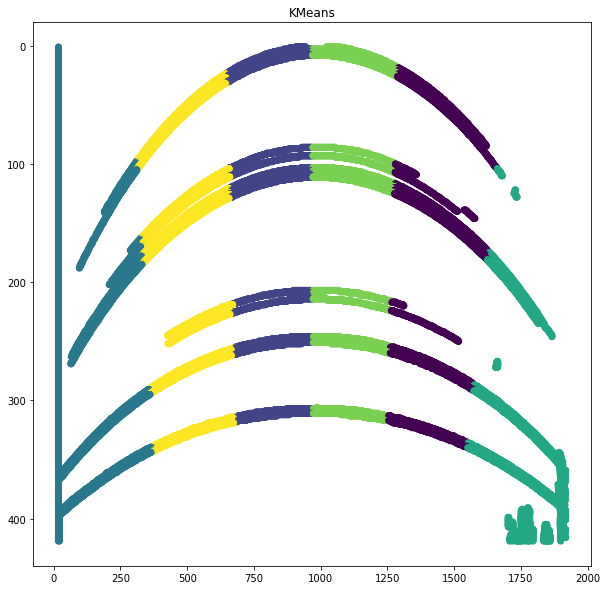

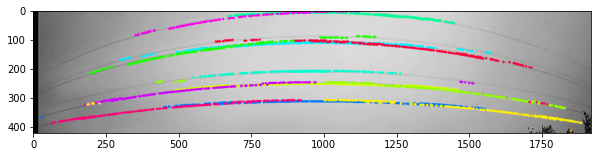

In [5]:
from sklearn.cluster import DBSCAN, KMeans

# some numpy tricks
row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points

y_pred = KMeans(n_clusters=6, random_state=10000).fit_predict(pts)
plt.figure(figsize=(10, 10))
plt.gca().invert_yaxis()
plt.scatter(pts[:, 0], pts[:, 1], c=y_pred)
plt.title('KMeans')

plt.figure(figsize=(10, 10))
roi_nemesis=nemesis[0:420, 0:]
plt.imshow(roi_nemesis)

# Calculculation of the Preference Matrix

### 1.0 Clustering with DBSCAN

From the roi extracted now we perform Dbscan.
We perform this task because we want to dimonstrate that with data effected by radial distortion a soft clustering approach is prefered.

In [6]:
from sklearn.cluster import DBSCAN, KMeans

# Clusters Utils

def get_cluster_pts(pts_clusters, cluster_label):
    return np.where(pts_clusters == cluster_label)[0]

def print_cluster(cluster_pts, pts, label, color="b"):
    coords = np.take(pts, cluster_pts, axis=0)
    plt.figure(figsize=(10, 10))
    plt.xlim(0, 1920)
    plt.ylim(420, 0)
    plt.scatter(coords[:, 0], coords[:, 1], 1, c=color)
    plt.title('Cluster {}'.format(label))
    
def info_cluster(cluster_label, cluster_pts):
    print("cluster {}] num of points:\t{}".format(cluster_label, cluster_pts.shape[0]))

def clusterize(pts, debug=True):
    db = DBSCAN(eps=3.5, min_samples=4).fit(pts)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.gca().invert_yaxis()
        plt.scatter(pts[:, 0], pts[:, 1], c=db.fit_predict(pts))
        plt.title('DBSCAN')

    pts_clusters=db.fit_predict(pts)
    num_clusters   = np.unique(pts_clusters).shape[0]
    clusters_label = np.unique(pts_clusters)
    if debug:
        print("num_clusters:\t {}\ncluster labels:\n {}".format(num_clusters, clusters_label))
    return pts_clusters, num_clusters, clusters_label

def get_all_clusters(pts):
    clusters = {}
    pts_clusters, num_clusters, clusters_label = clusterize(pts, debug=False)
    for l in clusters_label:
        clusters.update({l: get_cluster_pts(pts_clusters, l)})
    return clusters

### 2.0 Add Noise (25% of the data)

Soft Linkage is a robust algorithm.

In this experiment we add random noise on the input data so that the final solution does not correspond to a DBScan solution.

Here we have some functions that add noise to the input points

In [7]:
# Noise Utils

def get_random(pts, qty_noise=1000):
    noise = np.random.randint(low=(0, 0), high=(roi.shape[1], roi.shape[0]), size=(qty_noise, 2))
    print("num of pts {}, num of noise {}".format(pts.shape[0], noise.shape[0]))
    noise_x = noise[:, 0]
    noise_y = noise[:, 1]

    plt.figure()
    plt.scatter(noise_x, noise_y)
    plt.title('Random Data')
    return noise

def add_random(pts, noise):
    pts_new = pts.copy()
    return np.concatenate([pts_new, noise])

### 3.0 - Point Preference Evaluation

The preference of the point for a cluster is calculated as the distance of the point to the parabola that approximate the cluster.


For the approximation of the cluster we perform polynomial regression using Chebyshev polinomy.
For semplicity we specify a degree 2 such that `the models will be parabolas`, which could be a first tentative to represent the **barrel effect** which lines are subjected in a radial distortion space. 


In [8]:
from numpy.polynomial import Chebyshev as T

def evaluate(point, cluster_pts, all_pts, debug=True):
    # evaluate the approximation
    coords = np.take(all_pts, cluster_pts, axis=0)
    
    x = coords[:, 0]
    y = coords[:, 1]
    parabola = T.fit(x, y, deg=2, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.gca().invert_yaxis()
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, parabola(x_axis), 'b')
        
    # point
    xp     = point[0] 
    yp     = point[1]
    approx = parabola(xp)
    err    = np.abs(approx - yp)

    if debug:
        plt.plot(xp, yp, 'g.', markersize=10)
        plt.show()
    
    return err

### Execution
we extract the input points and we add random noise.

Then we perform DBScan. Here are shown our clustering result in a noisy environment

num of points (23003, 2)
num of pts 23003, num of noise 1150
num of points with random 24153


Text(0.5, 1.0, 'Experiment Points')

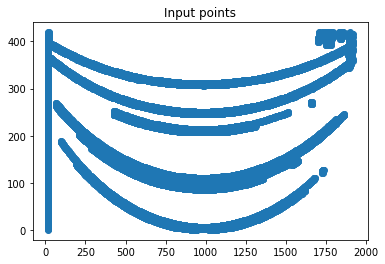

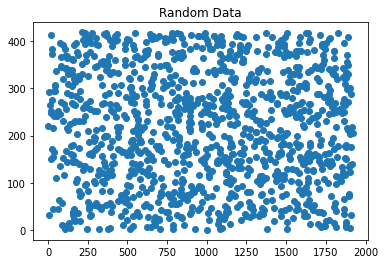

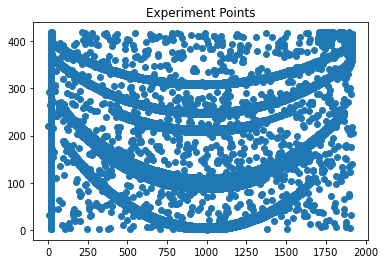

In [9]:
row, col = roi.nonzero()
or_pts = np.column_stack((col, row)) # this are the points

plt.figure()
plt.scatter(or_pts[:, 0], or_pts[:, 1])
plt.title('Input points')
print ("num of points {}".format(or_pts.shape))

# add + 25% random
noise = get_random(or_pts, round(or_pts.shape[0] * 0.05))
pts = add_random(or_pts, noise)
print ("num of points with random {}".format(pts.shape[0]))
plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])
plt.title('Experiment Points')

In [10]:
clusters = get_all_clusters(pts)

num_clusters:	 26
cluster labels:
 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24]


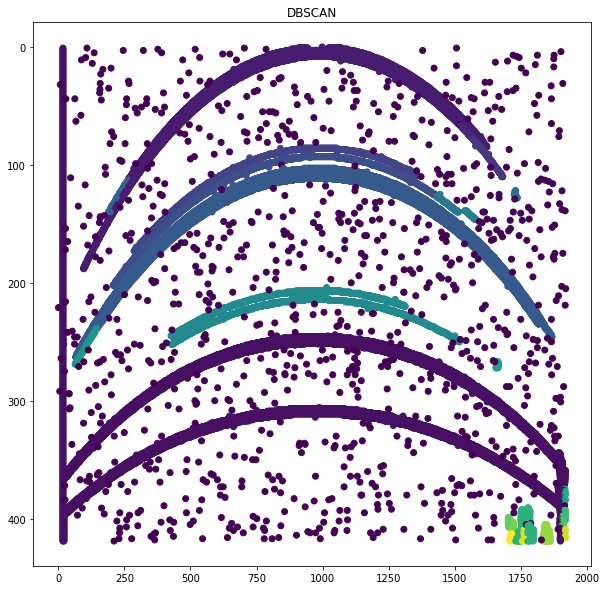

In [11]:
clusters = get_all_clusters(pts)
pts_clusters, num_clusters, clusters_label = clusterize(pts)


### In the Details: calculate preference row of point 2578
Here we calculate the preference of a sample point (point 2578). Later we will do this operation for each input points (also to the noisy points).

The main idea is the following:
* select one point
* for each cluster we evaluate the distance between the point and the model approximation of the cluster
* from the error we understand which are the prefered cluster by the point

The figures show:
* in green: the point 2578
* in reed: the point of the cluster
* in blue: the parabola which approximate the cluster


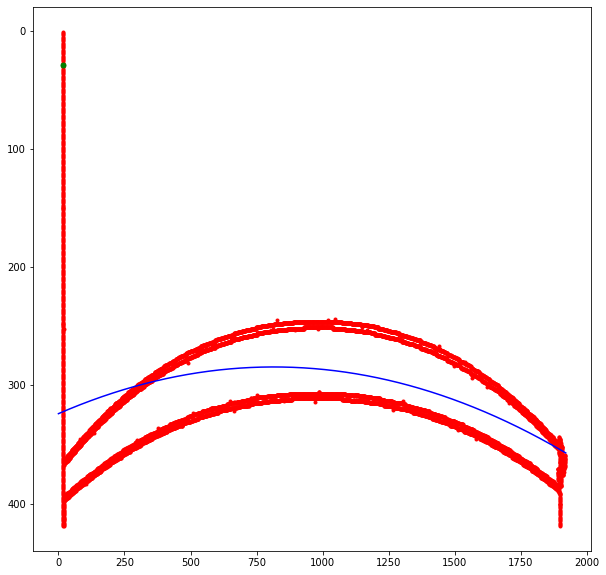

error: 293.171809872221


In [12]:
# point to cluster dictionary
p_to_cluster = {}
for i in range(len(pts)):
    p_to_cluster.update({i: pts_clusters[i]})

# evaluate inside that cluster
error = evaluate(pts[2578], clusters[p_to_cluster[2578]], pts)
print('error: {}'.format(error))

In [13]:
def evaluate_all(point, all_clusters, all_pts, debug=True):
    
    eval_row = []
    for label in all_clusters.keys():
                
        error = evaluate(point, all_clusters[label], all_pts, debug=debug)
        eval_row.append(error)
    
    return eval_row

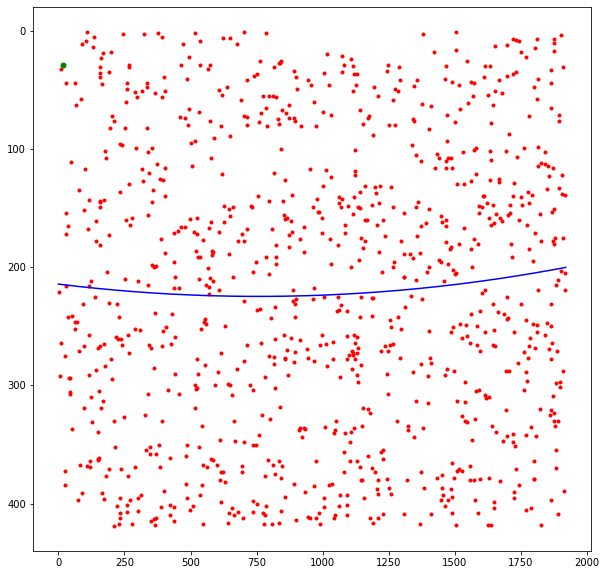

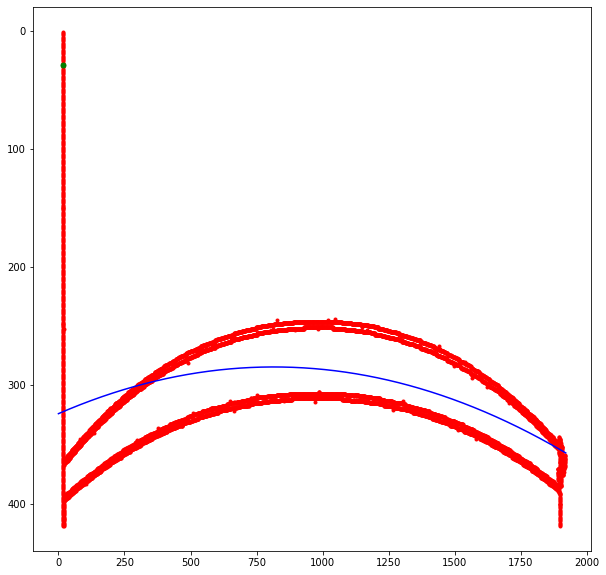

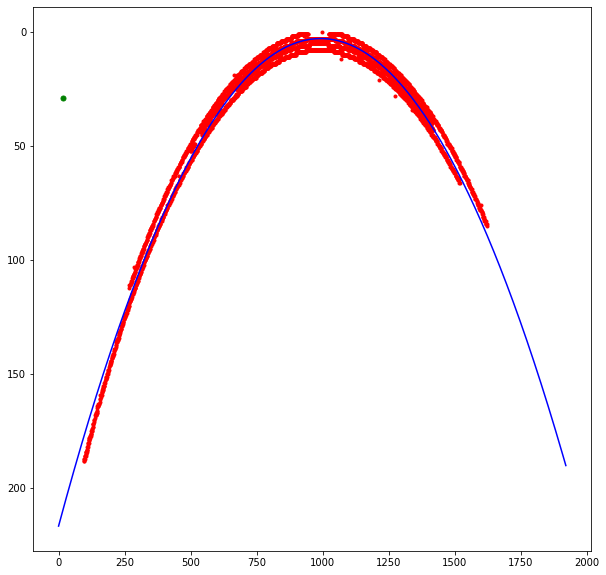

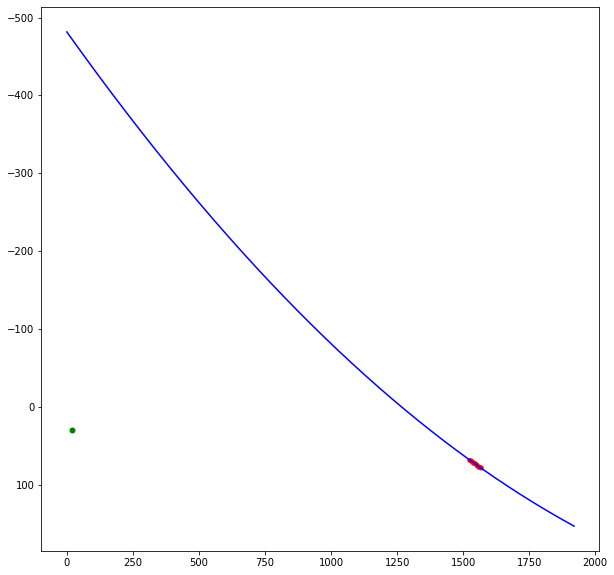

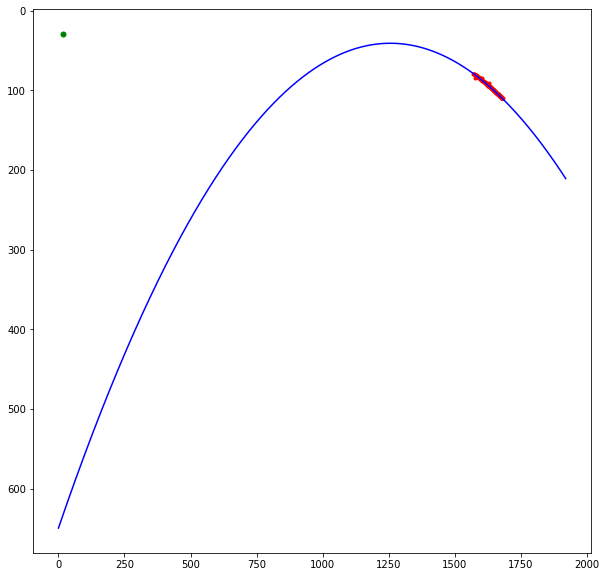

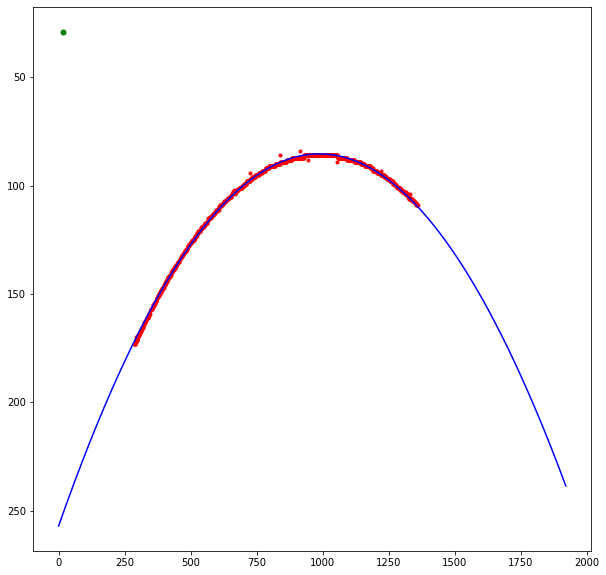

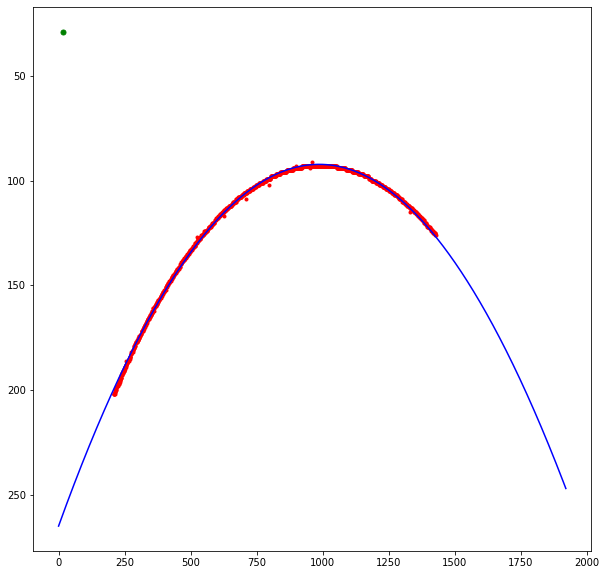

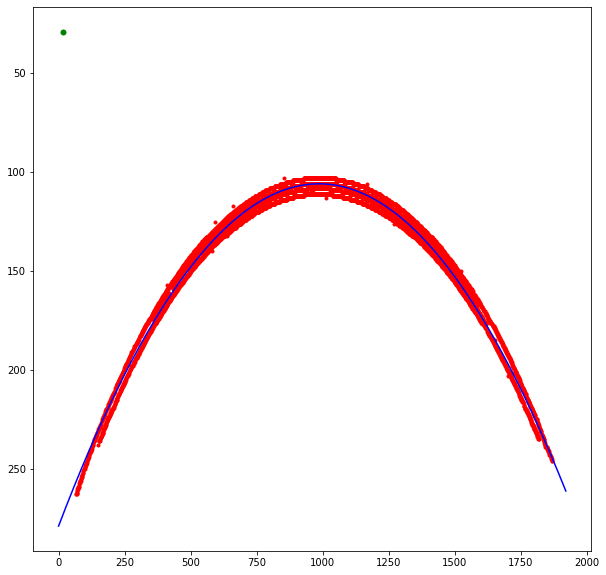

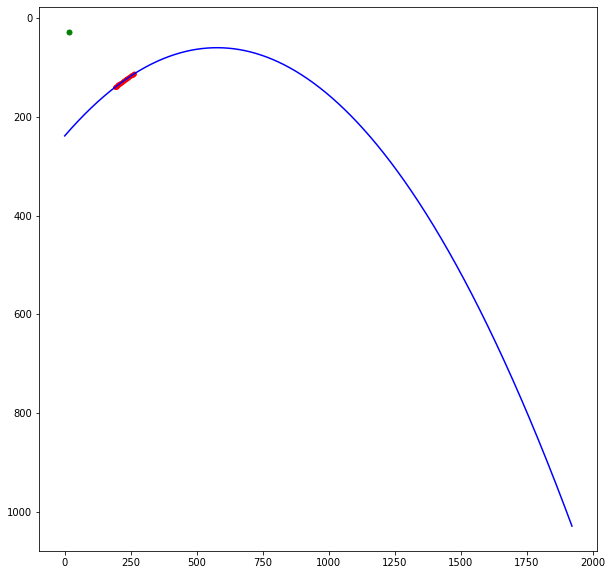

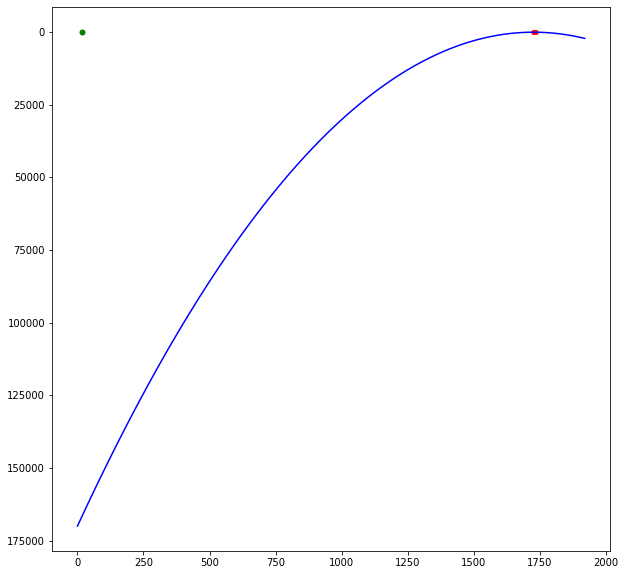

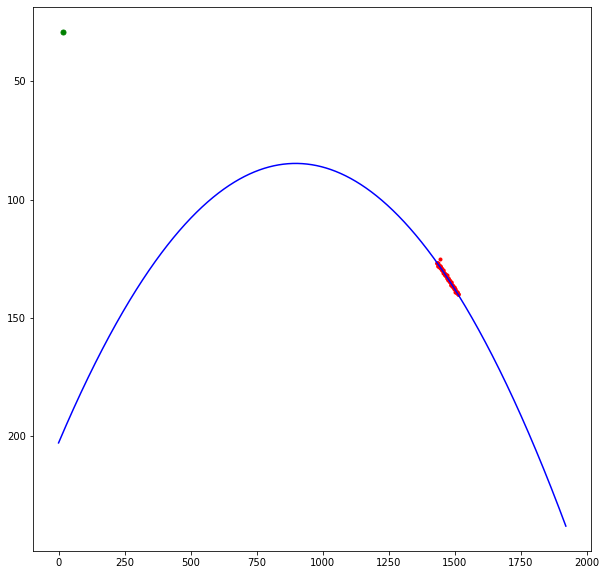

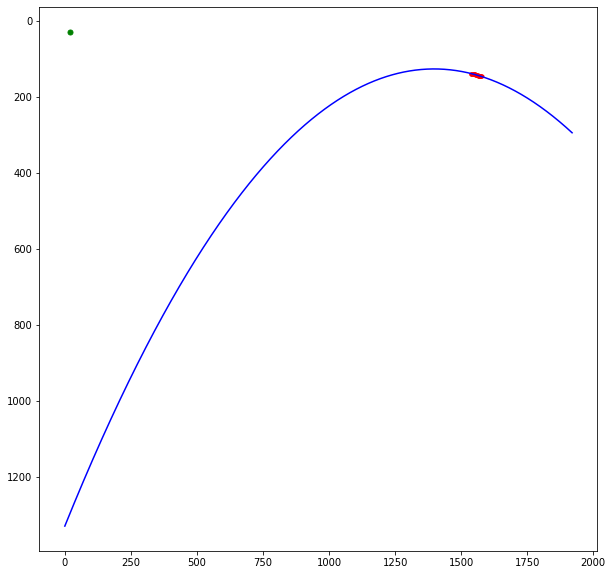

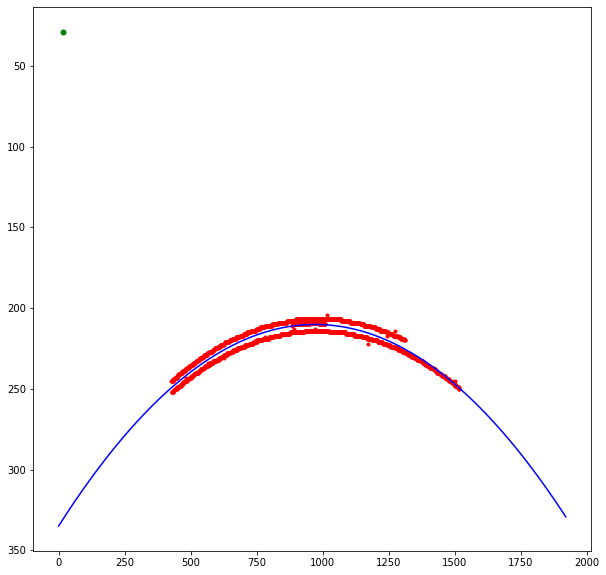

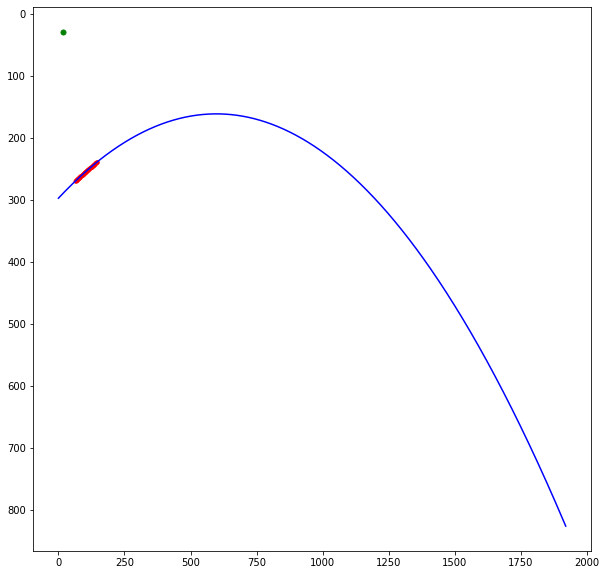

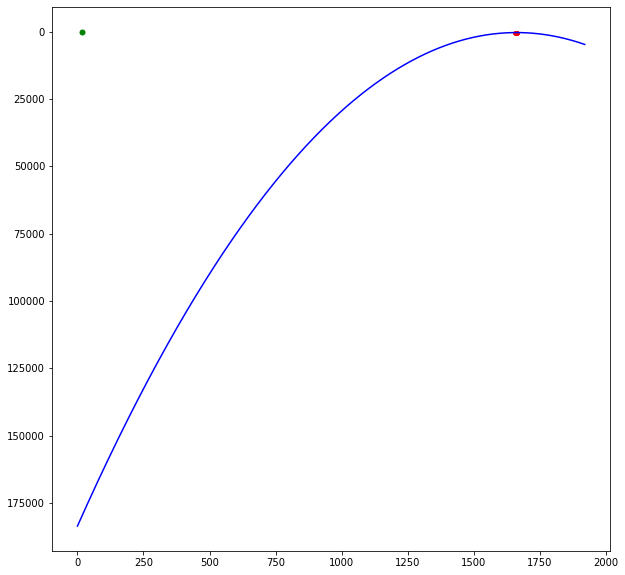

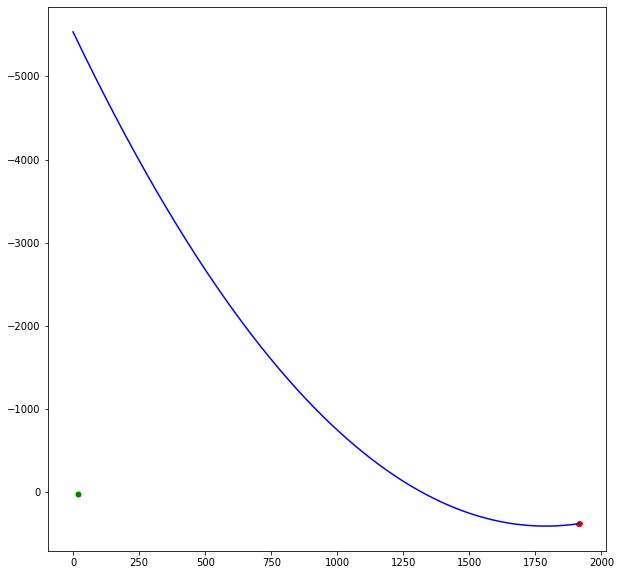

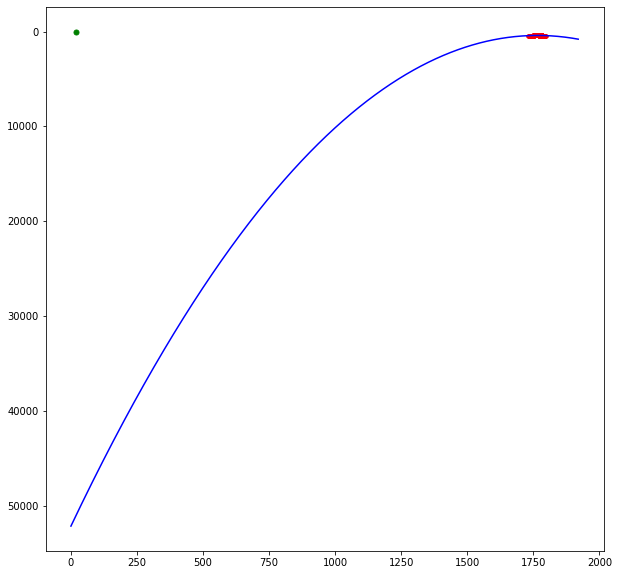

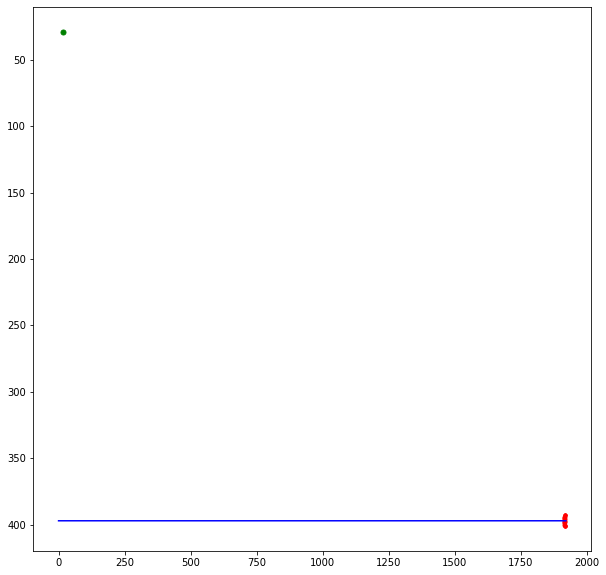

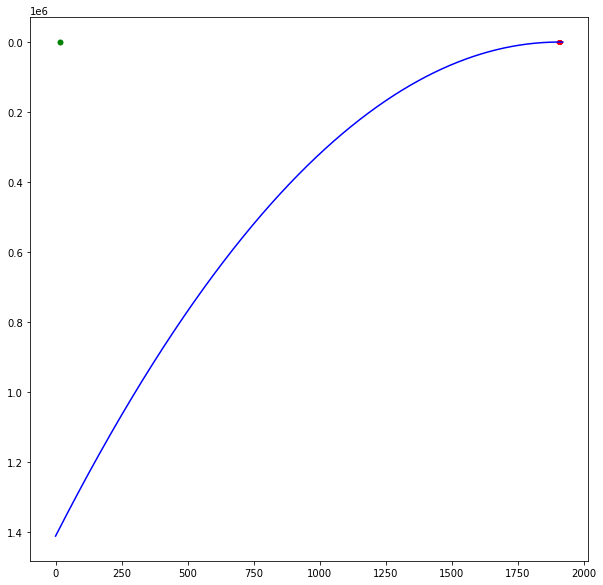

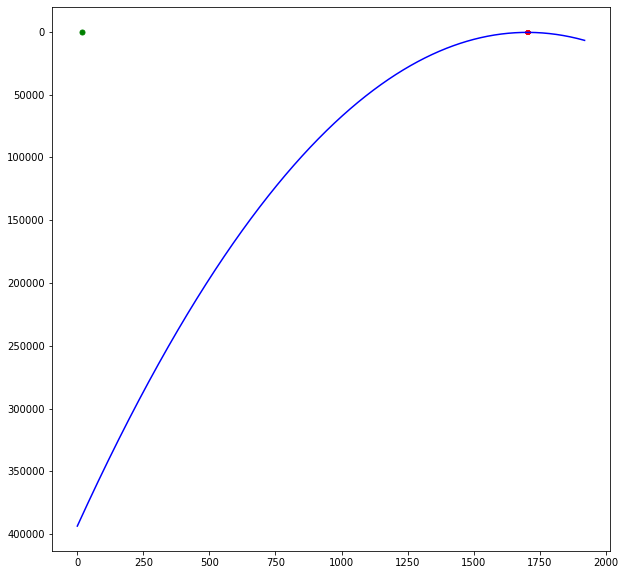

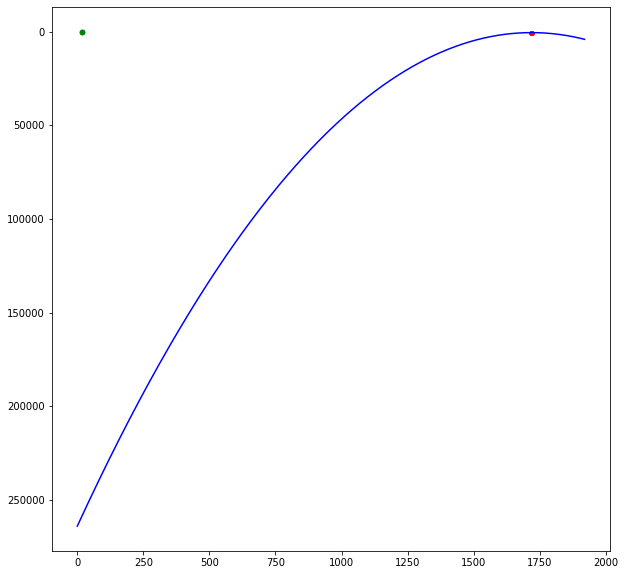

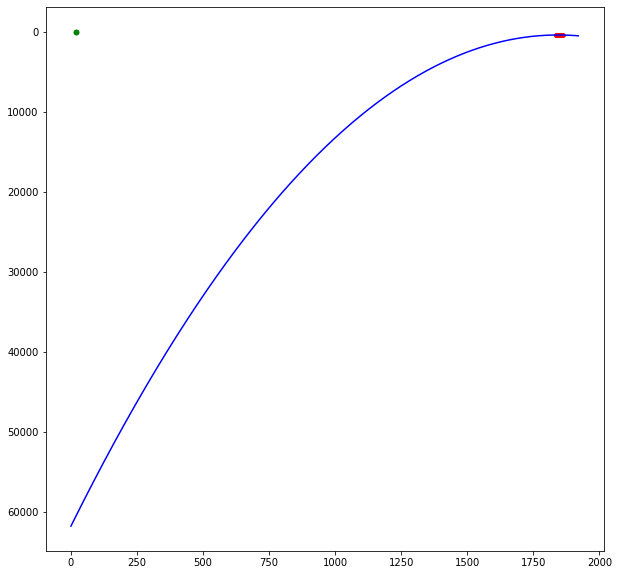

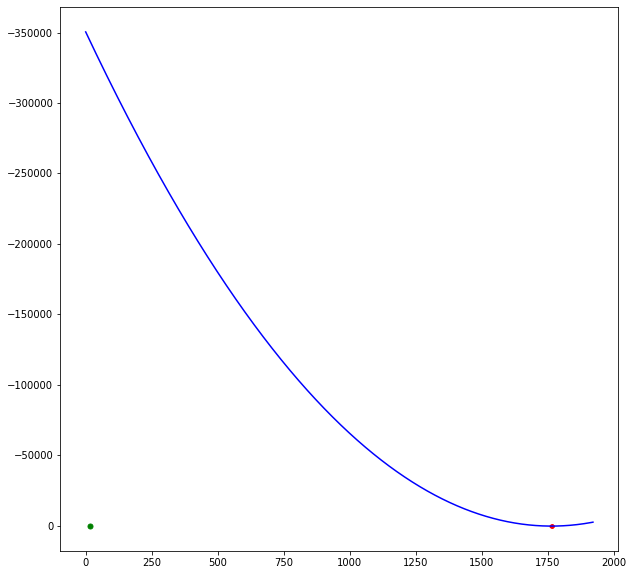

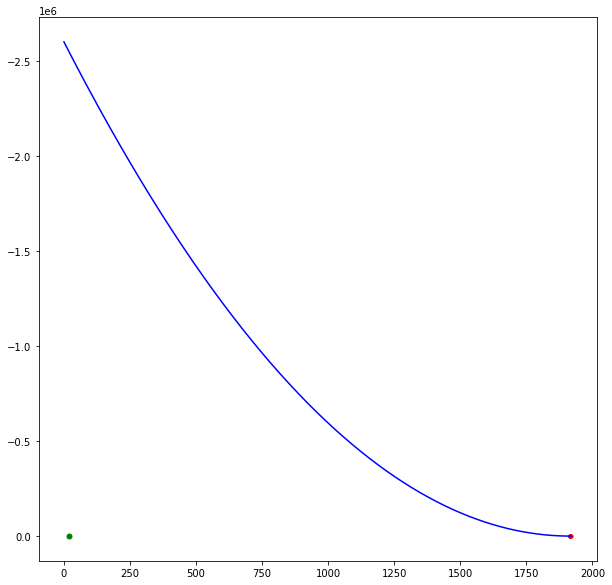

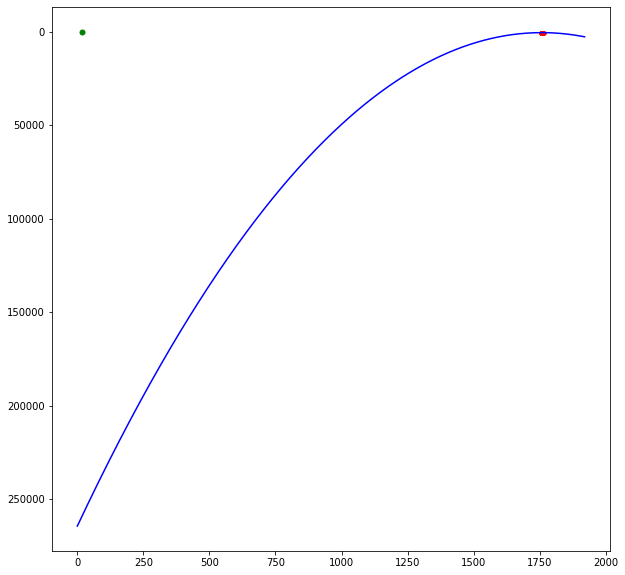

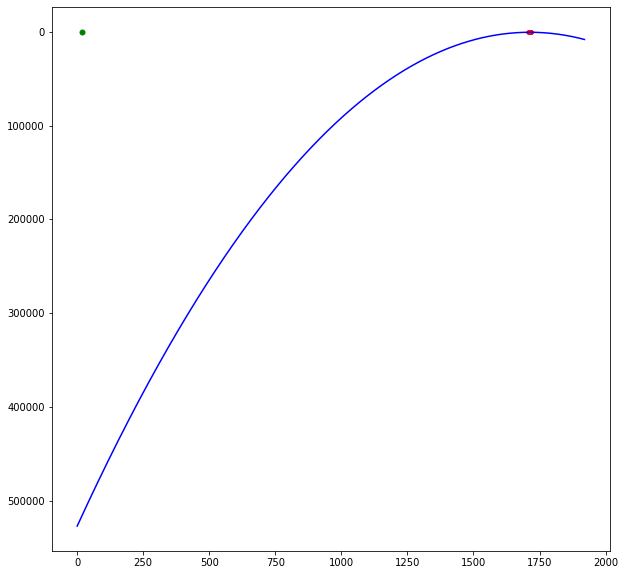

[185.80928444666063,
 293.171809872221,
 179.85220855442054,
 502.0036527076895,
 603.3869589078797,
 221.84078777163958,
 229.67236997961055,
 243.72519166787538,
 199.15955146886526,
 166353.40462954433,
 169.33589627111454,
 1270.1668043004943,
 301.4066984271841,
 259.9420097219599,
 179637.21507130095,
 5445.429467740439,
 51052.44502962262,
 367.99999950554627,
 1385950.611047063,
 385288.80110086856,
 258506.0764329889,
 60548.54185050592,
 343385.96774179593,
 2553137.500000159,
 258826.3153042682,
 515892.4621193392]

In [14]:
evaluate_all(pts[2578], clusters, pts)

### Get Preference Matrix

Now we perform the same procedure we showed above to each point of the roi.

Take care that some clusters got from DBScan are not interesting (they are just a bunch of noisy edges), so their model are impossible parabolas approximation.
For this reason we may have errors that sometimes are too big. 

The idea is to limit the error to `err = min(error, max height of the image)`


In [15]:
# Preference matrix utils
import seaborn as sn
import time

def print_preference_matrix(matrix):
    fig, ax = plt.subplots(figsize=(15,15))         
    sn.heatmap(matrix, cmap="binary", yticklabels=False)


def get_preference_matrix(all_clusters : dict, all_pts : np.array, limit=False, step_debug=50):

    # time utils
    start_time = time.time()
    
    matrix = np.zeros(shape=(all_pts.shape[0], len(all_clusters.keys())), dtype=int)    

    step_time = time.time()
    for i in range(all_pts.shape[0]):
        if i == limit:
            break
        
        point = all_pts[i]
        row = evaluate_all(point, all_clusters, all_pts, debug=False)
        matrix[i, :] = matrix[i, :] + row
        
        # step time end
        if i % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(i, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()
        
    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
    return matrix



In [16]:
matrix = get_preference_matrix (clusters, pts, limit= None, step_debug=1000)

0] took: 0.04823 s
1000] took: 0.22533 s
2000] took: 0.59881 s
3000] took: 0.40851 s
4000] took: 0.57251 s
5000] took: 0.05994 s
6000] took: 0.18308 s
7000] took: 0.12159 s
8000] took: 0.04427 s
9000] took: 0.08435 s
10000] took: 0.05592 s
11000] took: 0.05565 s
12000] took: 0.04030 s
13000] took: 0.06887 s
14000] took: 0.05178 s
15000] took: 0.07386 s
16000] took: 0.07024 s
17000] took: 0.06827 s
18000] took: 0.07328 s
19000] took: 0.06947 s
20000] took: 0.06218 s
21000] took: 0.04594 s
22000] took: 0.07291 s
23000] took: 0.15355 s
24000] took: 0.09518 s
Completed! total time: 00 h 02 m 52 s


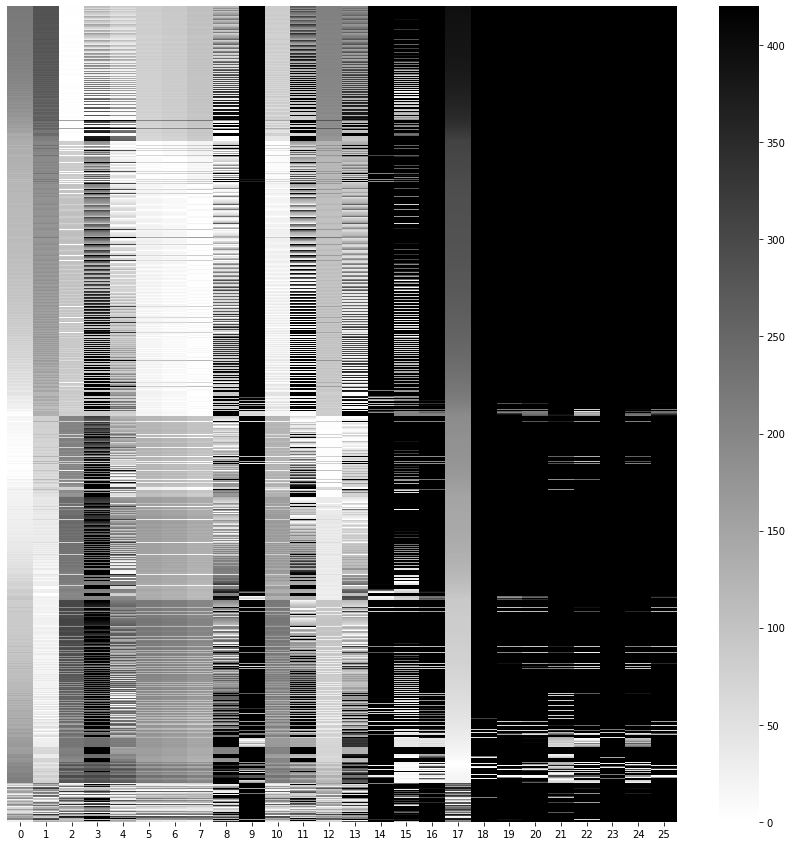

In [17]:
matrix_backup = matrix.copy()

# truncate when distance is > of the image (impossible parabolas)
threshold = roi.shape[0]
matrix[matrix>threshold] = threshold

print_preference_matrix(matrix)

### Prererence Matrix - analysis

So we obtained our starting preference matrix. 

Black means that error is high while white means error is low.

So just looking to the preference matrix we see for example that cluster 5 and 6 have pretty similar preferences. Just printing these clusters shows that actually cluster 5 is pretty similar to cluster 6


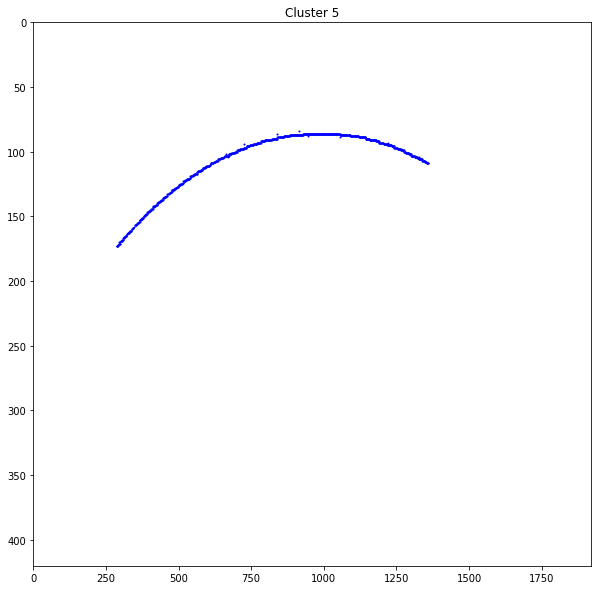

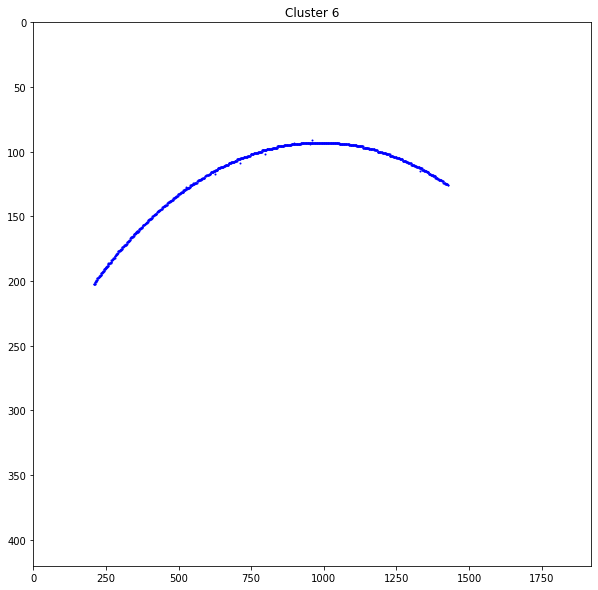

In [18]:
# cluster 5 in the figure is cluster 4 in code!
# cluster 6 in the figure is cluster 5 in code!
# (reminder -1 is the cluster label of dbscan for the noise)

print_cluster(clusters[4], pts, '5')
print_cluster(clusters[5], pts, '6')

### Preference Matrix analysis
to decide cluster merging we can can adopt two ways:
* compute similarity between rows
* compute similarity between columns

In [19]:
from scipy.spatial.distance import cosine
s_56  = cosine(matrix[:, 4], matrix[:, 5])
s_015 = cosine(matrix[:, 19], matrix[:, 20])

print('similarity cluster 5 - 6:(0:=equals, 1:= different) {}'.format(s_56))
print('similarity cluster 0 - 15:(0:=equals, 1:= different) {}'.format(s_015))

similarity cluster 5 - 6:(0:=equals, 1:= different) 0.1903740643780938
similarity cluster 0 - 15:(0:=equals, 1:= different) 0.0021650185241266495


In [32]:
from scipy.spatial.distance import cosine

def columns_similarity(matrix):
    similarity_matrix = np.zeros(shape=(matrix.shape[1], matrix.shape[1]))
    for i in range(matrix.shape[1]):
        for j in range(matrix.shape[1]):
            similarity = cosine(matrix[:, i], matrix[:, j])
            similarity_matrix[i, j] = similarity
    # normalize
    row_sums = similarity_matrix.sum(axis=1)
    similarity_matrix = similarity_matrix/row_sums[:, np.newaxis]
    
    # add infinite to diagonals    
    return similarity_matrix

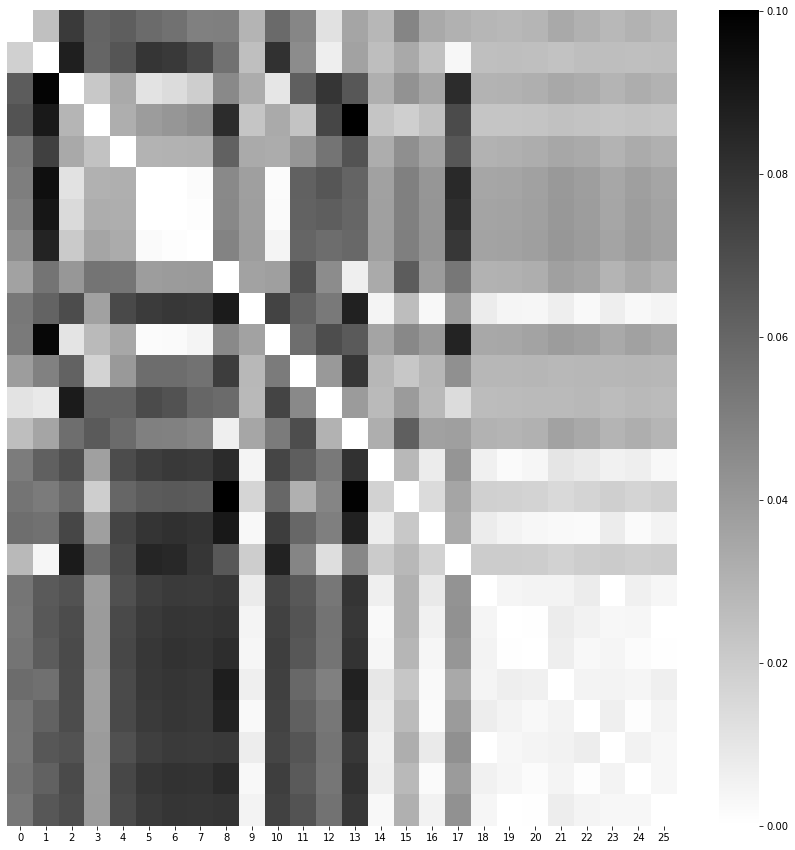

In [33]:
similarity_matrix = columns_similarity(matrix)
print_preference_matrix(similarity_matrix)

In [79]:
from operator import attrgetter

class ClusterRelation:
    def __init__(self, **kwargs):
        self.cluster_i  = kwargs.get('cluster_i')
        self.cluster_o  = kwargs.get('cluster_o')
        self.similarity = kwargs.get('similarity')

    def __str__(self):
        return "cluster_i: {} -> cluster_o: {} similarity: {}".format(self.cluster_i, self.cluster_o, self.similarity)
    def __repr__(self):
        return self.__str__()
    
def bestClusterRelation(allClusterRelations):
    return min([c for c in allClusterRelations if c.cluster_i != -1], key=attrgetter('similarity'))

def getClusterRelations(matrix):
    similarity_matrix = matrix.copy()
    np.fill_diagonal(similarity_matrix, np.inf)
    choices = []
    for row in range(similarity_matrix.shape[0]):
        best         = similarity_matrix[row, :].min()
        cluster_best = similarity_matrix[row, :].argmin()
        choices.append(ClusterRelation(cluster_i=row-1, cluster_o=cluster_best - 1, similarity=best))
    return choices

In [115]:
a = getClusterRelations(similarity_matrix)
print(a)
best= bestClusterRelation(a)

[cluster_i: -1 -> cluster_o: 11 similarity: 0.011967774713979246, cluster_i: 0 -> cluster_o: 16 similarity: 0.003206880299266862, cluster_i: 1 -> cluster_o: 9 similarity: 0.009988612449029342, cluster_i: 2 -> cluster_o: 14 similarity: 0.018864160474680983, cluster_i: 3 -> cluster_o: 2 similarity: 0.024007019838504593, cluster_i: 4 -> cluster_o: 5 similarity: 0.00023444236383092344, cluster_i: 5 -> cluster_o: 4 similarity: 0.00023273475666126762, cluster_i: 6 -> cluster_o: 5 similarity: 0.0009350958211089926, cluster_i: 7 -> cluster_o: 12 similarity: 0.006484501108159097, cluster_i: 8 -> cluster_o: 21 similarity: 0.0025760036303666355, cluster_i: 9 -> cluster_o: 4 similarity: 0.0015895160599878266, cluster_i: 10 -> cluster_o: 2 similarity: 0.01724820422556472, cluster_i: 11 -> cluster_o: 0 similarity: 0.008640507173300291, cluster_i: 12 -> cluster_o: 7 similarity: 0.006389442601833738, cluster_i: 13 -> cluster_o: 18 similarity: 0.0022760434879400657, cluster_i: 14 -> cluster_o: 15 simil

In [116]:
def aggregate_cluster(clusters, clusters_label, best_cluster_relation):
    cluster_i = best_cluster_relation.cluster_i
    cluster_o = best_cluster_relation.cluster_o
    
    new_clusters = clusters.copy()
    new_clusters_label = clusters_label.copy()
    
    new_clusters[cluster_o] = np.append(clusters[cluster_o], clusters[cluster_i])
    del (new_clusters[cluster_i])
    
    label_to_delete = np.argwhere(clusters_label==cluster_i).ravel()
    new_clusters_label = np.delete(clusters_label, label_to_delete)
    
    return new_clusters, new_clusters_label

In [89]:
clusters[19]

array([22570, 22571, 22572, 22587, 22588, 22589, 22590, 22605, 22606,
       22626, 22627, 22650, 22651, 22664, 22665, 22666, 22667, 22684,
       22685])

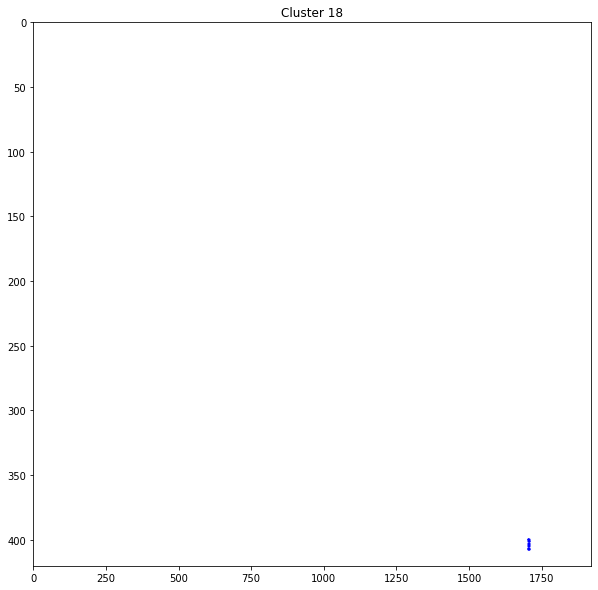

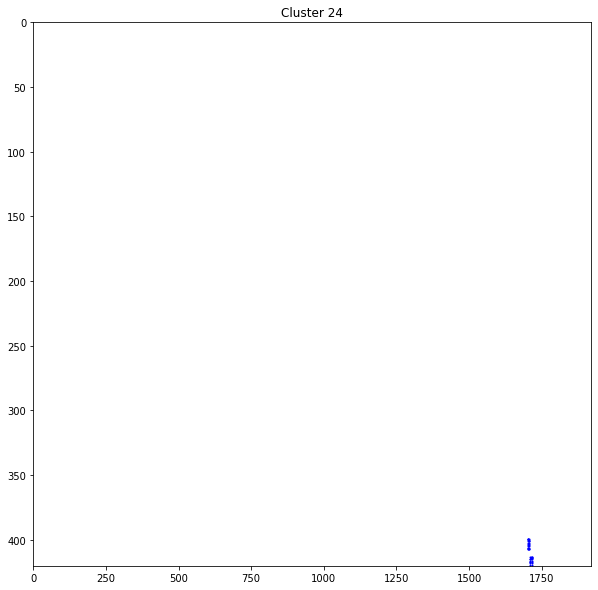

In [119]:
clusters = get_all_clusters(pts)
pts_clusters, num_clusters, clusters_label = clusterize(pts, debug=False)


allClusterRelations = getClusterRelations(similarity_matrix)
best = bestClusterRelation(allClusterRelations)
print_cluster(clusters[best.cluster_i], pts, best.cluster_i)

clusters, clusters_label = aggregate_cluster(clusters, clusters_label, best)
print_cluster(clusters[best.cluster_o], pts, best.cluster_o)


In [121]:
clusters_label
clusters

{-1: array([ 3681, 22317, 22597, 23004, 23005, 23006, 23007, 23008, 23009,
        23010, 23012, 23013, 23014, 23015, 23016, 23017, 23018, 23019,
        23020, 23021, 23022, 23023, 23024, 23025, 23027, 23028, 23029,
        23032, 23035, 23036, 23037, 23038, 23039, 23040, 23041, 23042,
        23043, 23044, 23045, 23046, 23047, 23048, 23051, 23053, 23054,
        23055, 23056, 23058, 23060, 23061, 23062, 23063, 23064, 23067,
        23068, 23069, 23070, 23071, 23072, 23073, 23077, 23078, 23079,
        23080, 23081, 23082, 23083, 23084, 23085, 23086, 23088, 23089,
        23090, 23091, 23092, 23093, 23094, 23095, 23098, 23099, 23101,
        23102, 23103, 23104, 23105, 23106, 23109, 23110, 23111, 23112,
        23114, 23115, 23116, 23118, 23120, 23121, 23122, 23123, 23124,
        23125, 23126, 23127, 23128, 23129, 23130, 23131, 23132, 23133,
        23134, 23135, 23136, 23137, 23138, 23139, 23140, 23142, 23143,
        23144, 23145, 23146, 23148, 23149, 23151, 23152, 23155, 23156,
  

num of pts 23003, num of noise 1150
0] took: 0.00765 s
1000] took: 0.38182 s
2000] took: 0.36861 s
3000] took: 0.52211 s
4000] took: 0.36734 s
5000] took: 0.36141 s
6000] took: 0.35683 s
7000] took: 0.40035 s
8000] took: 0.36149 s
9000] took: 0.40062 s
10000] took: 0.33797 s
11000] took: 0.36947 s
12000] took: 0.44862 s
13000] took: 0.46574 s
14000] took: 0.55614 s
15000] took: 0.53548 s
16000] took: 0.41648 s
17000] took: 0.35555 s
18000] took: 0.36037 s
19000] took: 0.49349 s
20000] took: 0.41363 s
21000] took: 0.33966 s
22000] took: 0.38665 s
23000] took: 0.32875 s
24000] took: 0.37433 s
Completed! total time: 00 h 02 m 58 s
0] took: 0.00704 s
1000] took: 0.00062 s
2000] took: 0.19824 s
3000] took: 0.46213 s
4000] took: 0.29773 s
5000] took: 0.99787 s
6000] took: 0.04579 s
7000] took: 0.99773 s
8000] took: 0.03026 s
9000] took: 0.99031 s
10000] took: 0.97978 s
11000] took: 0.00370 s
12000] took: 0.25558 s
13000] took: 0.28436 s
14000] took: 0.68877 s
15000] took: 0.00839 s
16000] to

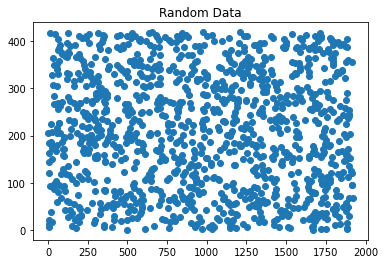

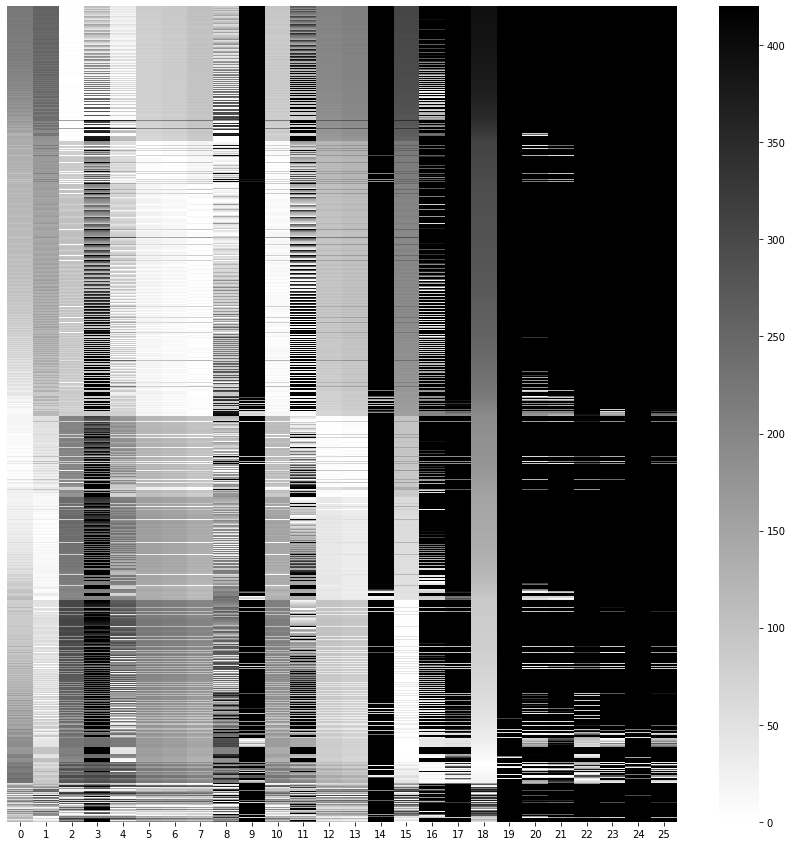

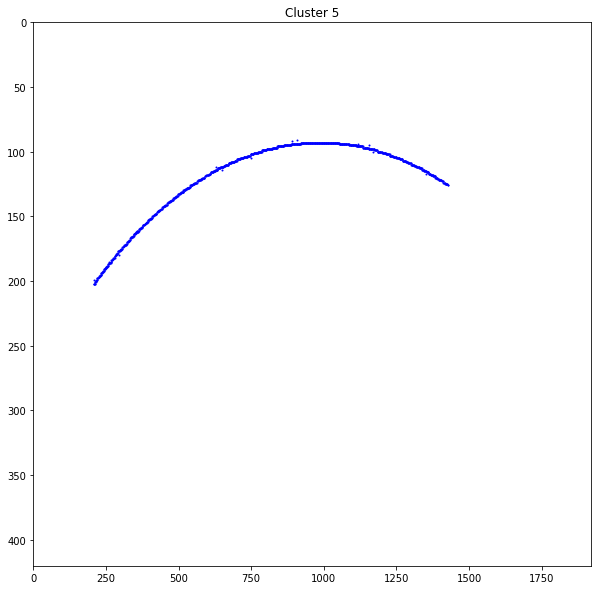

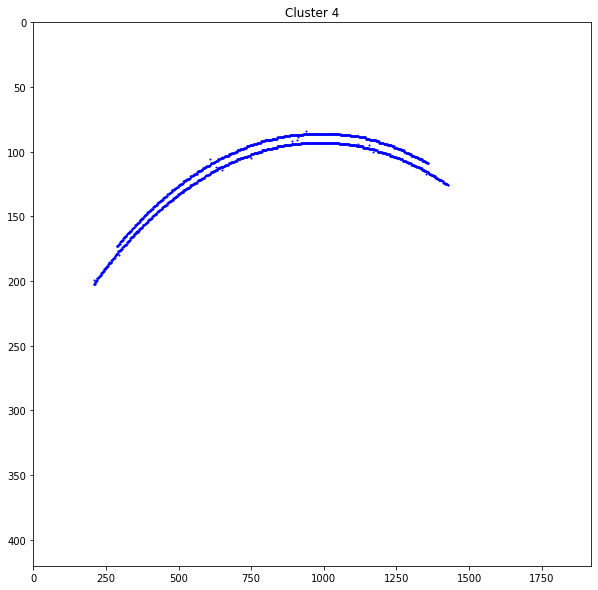

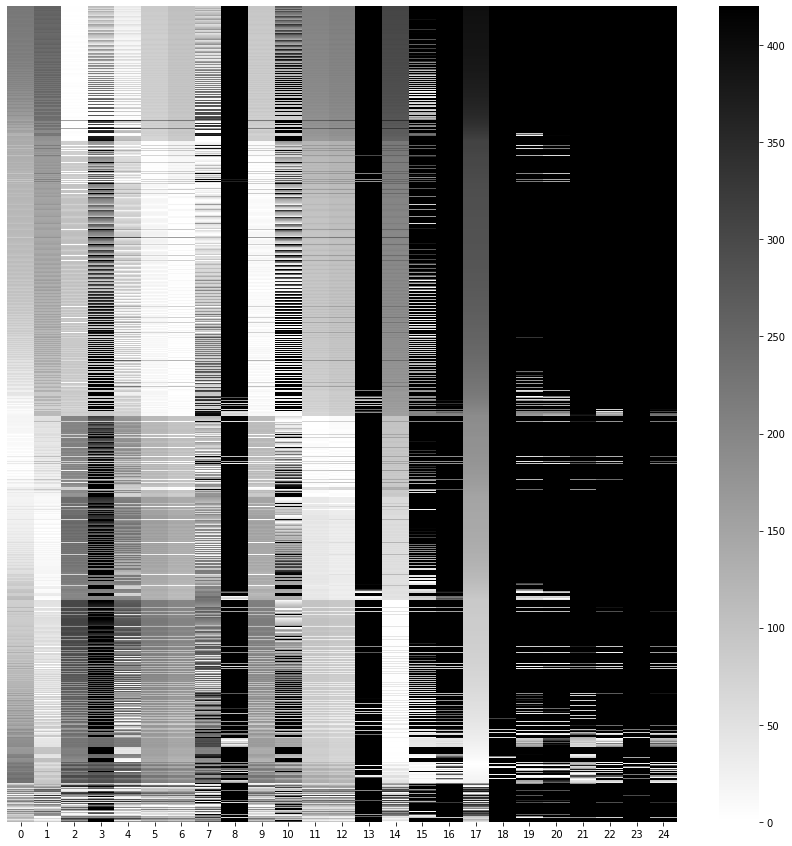

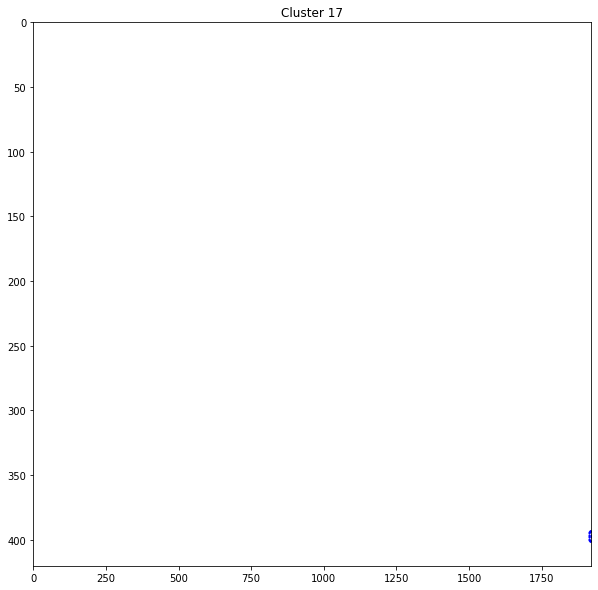

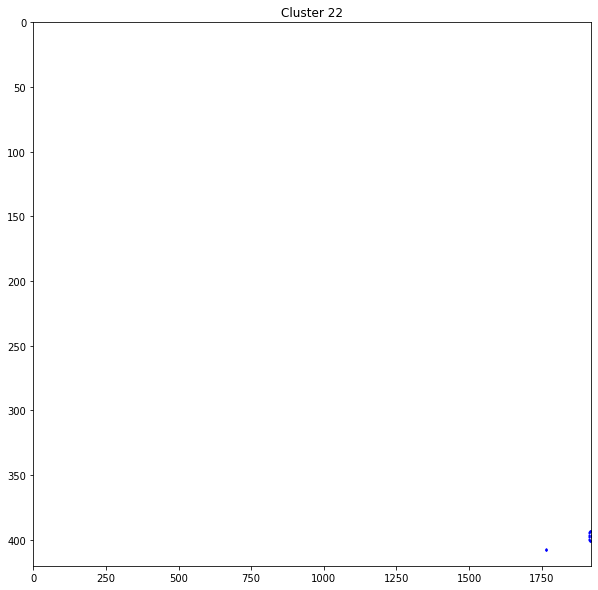

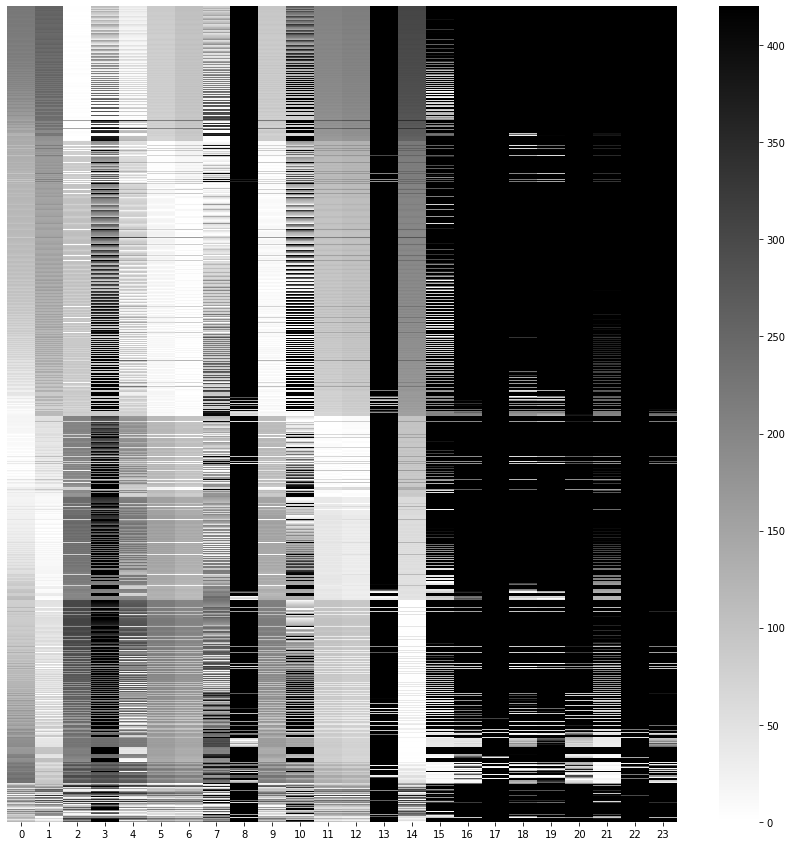

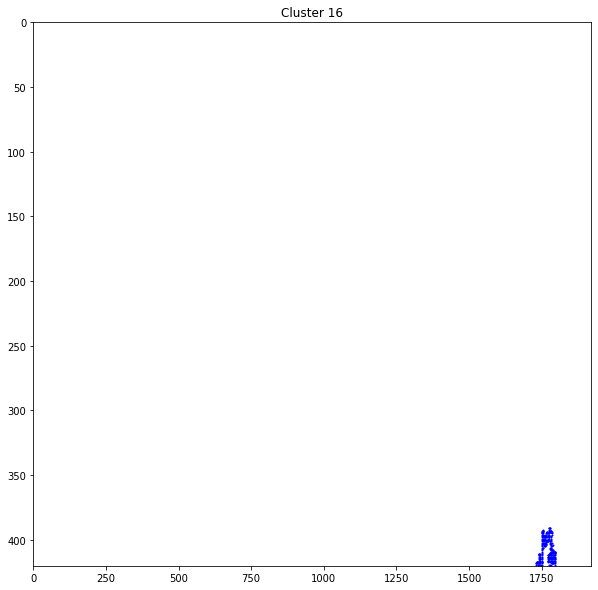

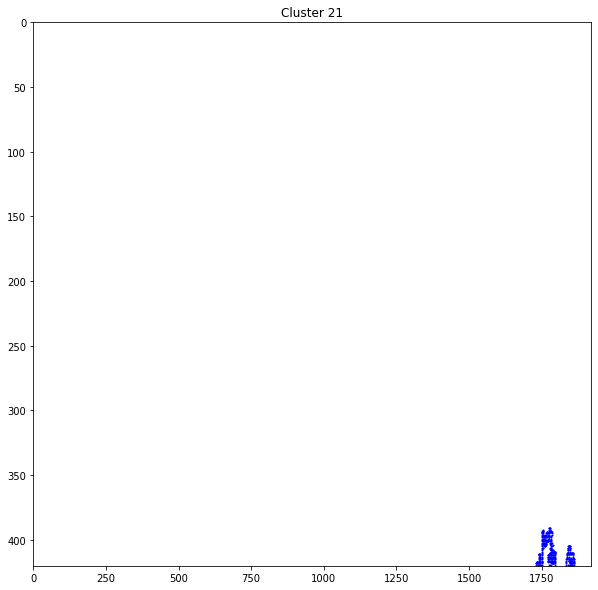

In [122]:
# get all points
row, col = roi.nonzero()
or_pts = np.column_stack((col, row)) # this are the points

# add + 5% random
noise = get_random(or_pts, round(or_pts.shape[0] * 0.05))
pts = add_random(or_pts, noise)

# get all clusters
clusters = get_all_clusters(pts)
pts_clusters, num_clusters, clusters_label = clusterize(pts, debug=False)


# method
for i in range(3):
    
    # get preference matrix
    matrix = get_preference_matrix (clusters, pts, limit= None, step_debug=1000)

    # truncate preference matrix
    threshold = roi.shape[0]
    matrix[matrix>threshold] = threshold
    print_preference_matrix(matrix)
    
    # calculate similarity matrix
    similarity_matrix = columns_similarity(matrix)

    # get cluster relations based on column similarity matrix
    allClusterRelations = getClusterRelations(similarity_matrix)
    best = bestClusterRelation(allClusterRelations)
    print("simplify cluster {}".format(best))
    print_cluster(clusters[best.cluster_i], pts, best.cluster_i)

    # modifiy the clusters
    clusters, clusters_label = aggregate_cluster(clusters, clusters_label, best)
    print_cluster(clusters[best.cluster_o], pts, best.cluster_o)


In [126]:
len(clusters_label)

23

In [125]:
print("simplify cluster {}".format(best))


simplify cluster cluster_i: 16 -> cluster_o: 21 similarity: 0.0003665032312111534


0] took: 0.01398 s
1000] took: 0.54702 s
2000] took: 0.52257 s
3000] took: 0.54359 s
4000] took: 0.54701 s
5000] took: 0.52621 s
6000] took: 0.51323 s
7000] took: 0.69071 s
8000] took: 0.51042 s
9000] took: 0.57136 s
10000] took: 0.50860 s
11000] took: 0.70678 s
12000] took: 0.51984 s
13000] took: 0.51402 s
14000] took: 0.56923 s
15000] took: 0.52173 s
16000] took: 0.54492 s
17000] took: 0.50043 s
18000] took: 0.51595 s
19000] took: 0.50275 s
20000] took: 0.52862 s
21000] took: 0.52438 s
22000] took: 0.96933 s
23000] took: 0.85510 s
24000] took: 0.81451 s
Completed! total time: 00 h 02 m 40 s
simplify cluster cluster_i: 15 -> cluster_o: 20 similarity: 0.0003672269127531255
0] took: 0.00688 s
1000] took: 0.07511 s
2000] took: 0.52310 s
3000] took: 0.53441 s
4000] took: 0.11206 s
5000] took: 0.16156 s
6000] took: 0.14215 s
7000] took: 0.14403 s
8000] took: 0.19214 s
9000] took: 0.14499 s
10000] took: 0.55870 s
11000] took: 0.16222 s
12000] took: 0.09969 s
13000] took: 0.12508 s
14000] to

KeyError: 8

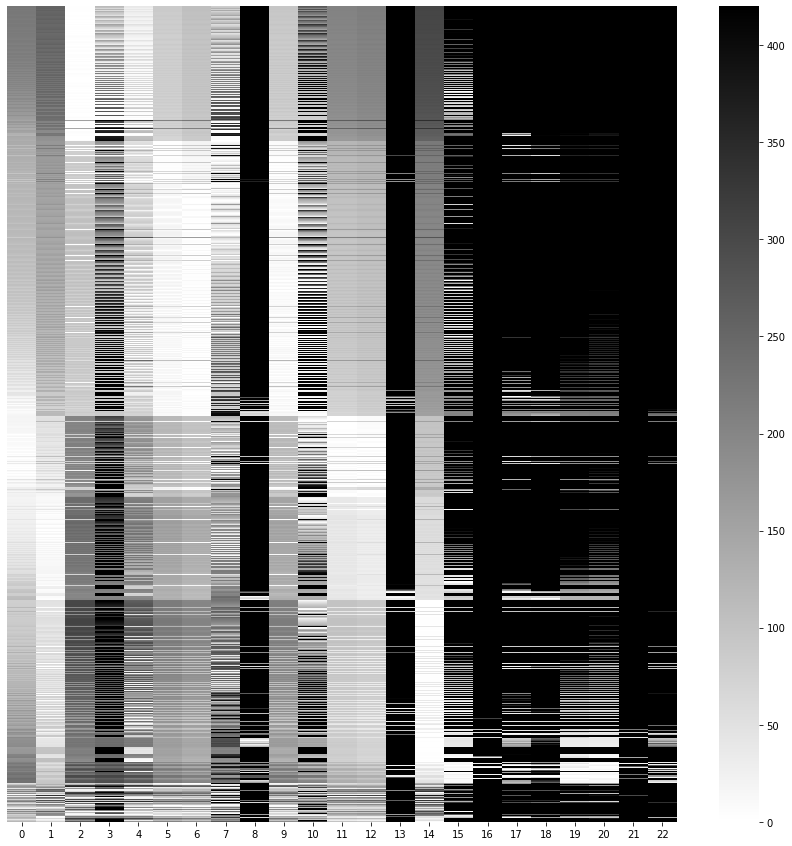

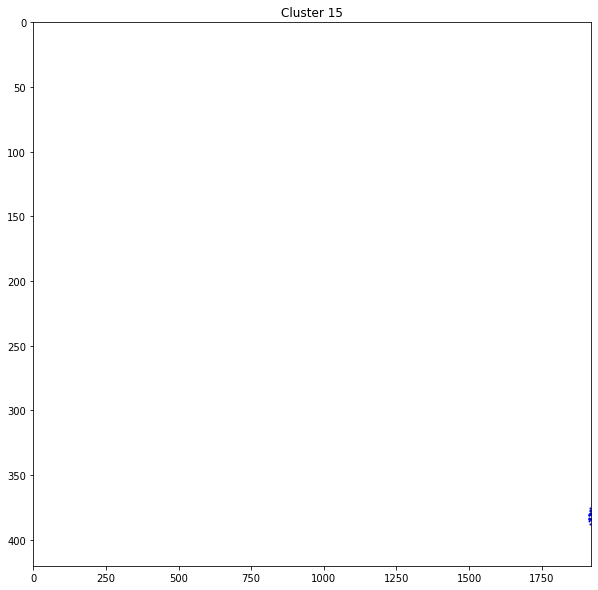

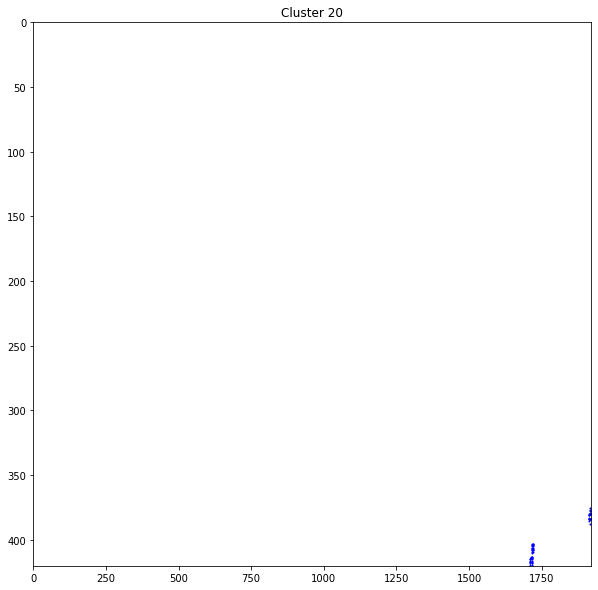

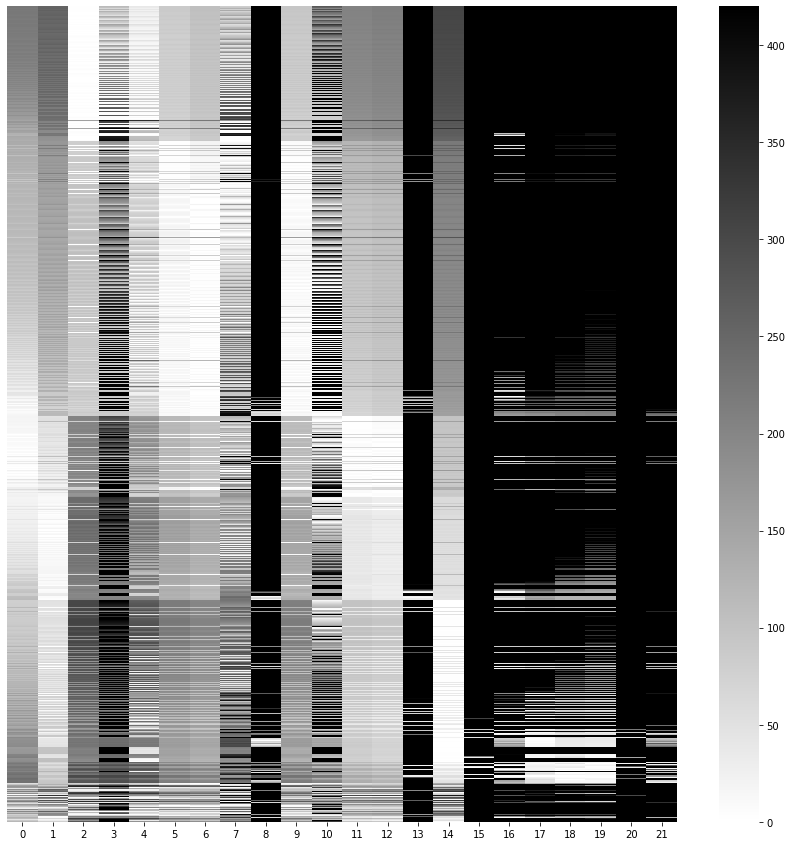

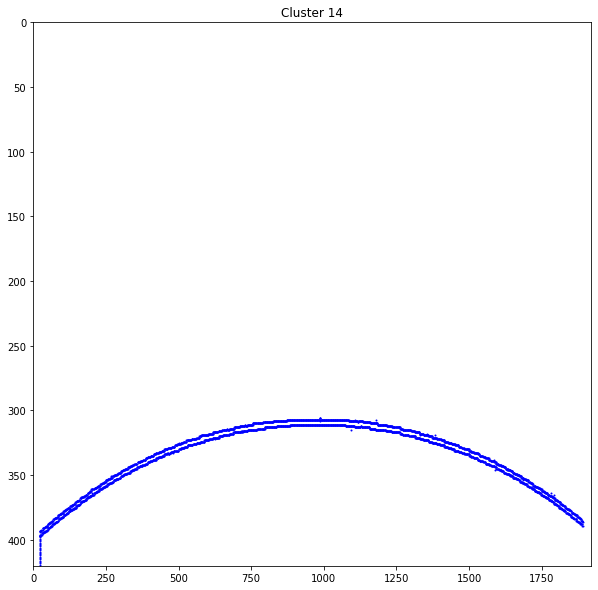

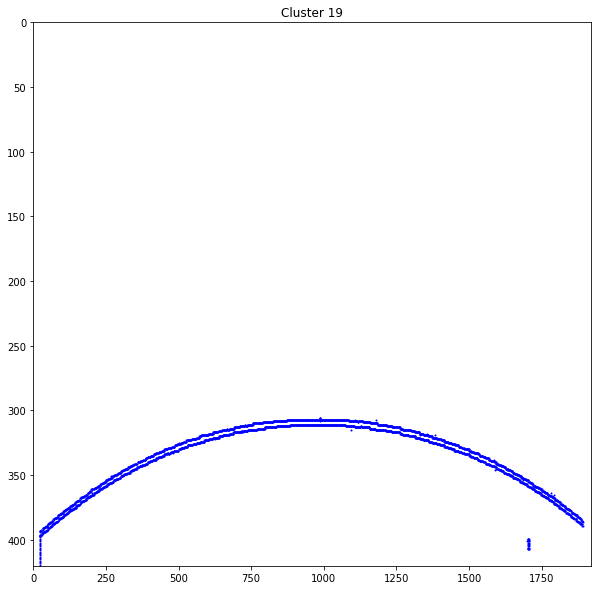

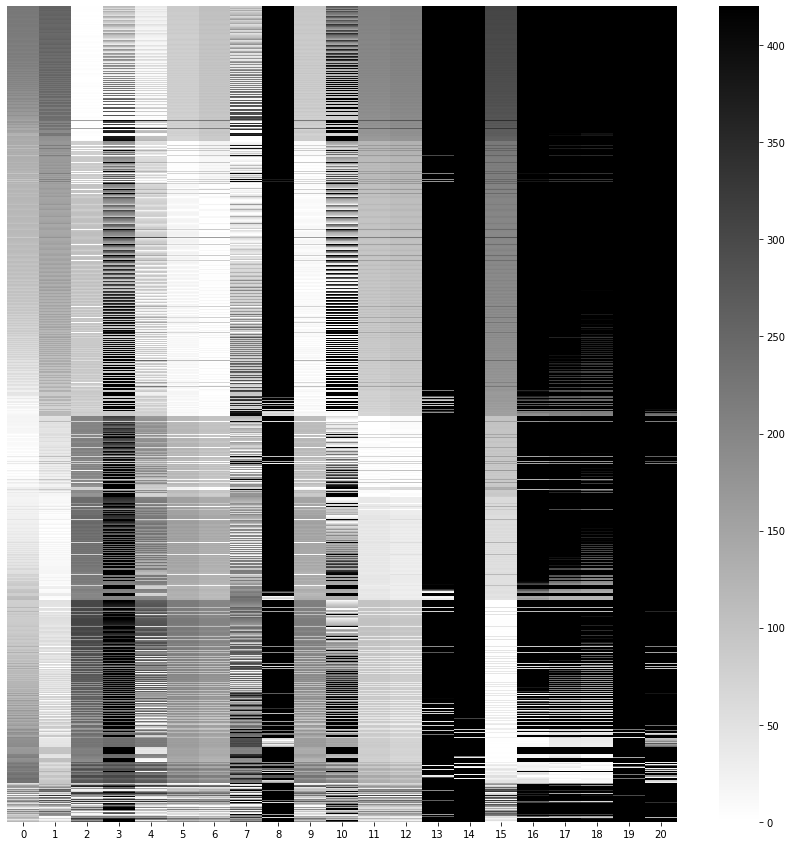

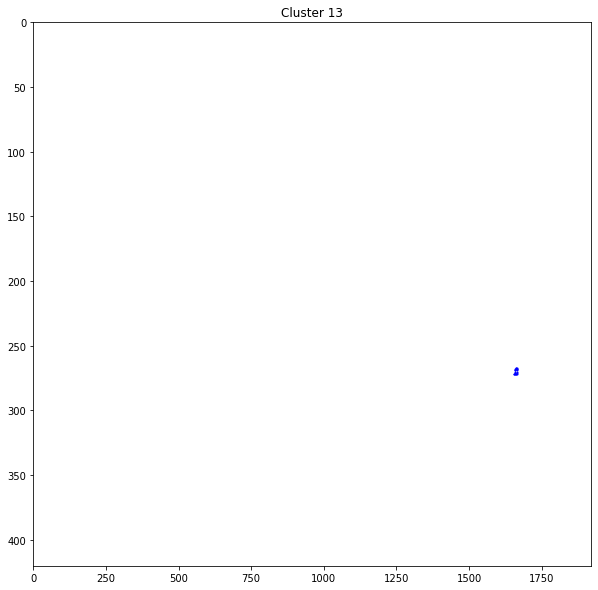

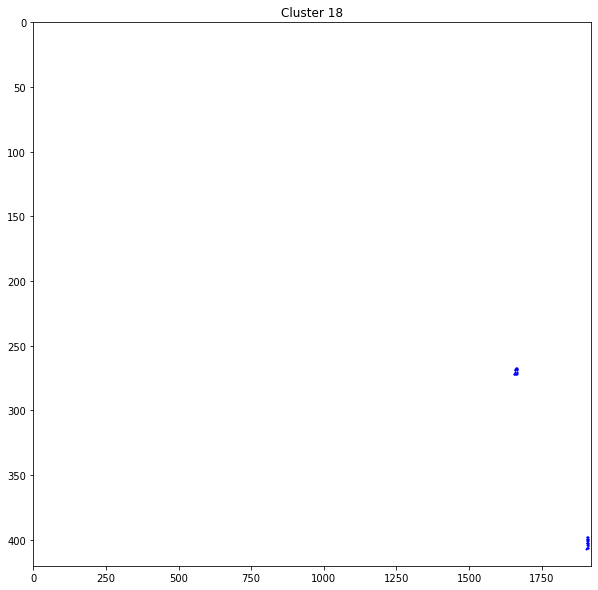

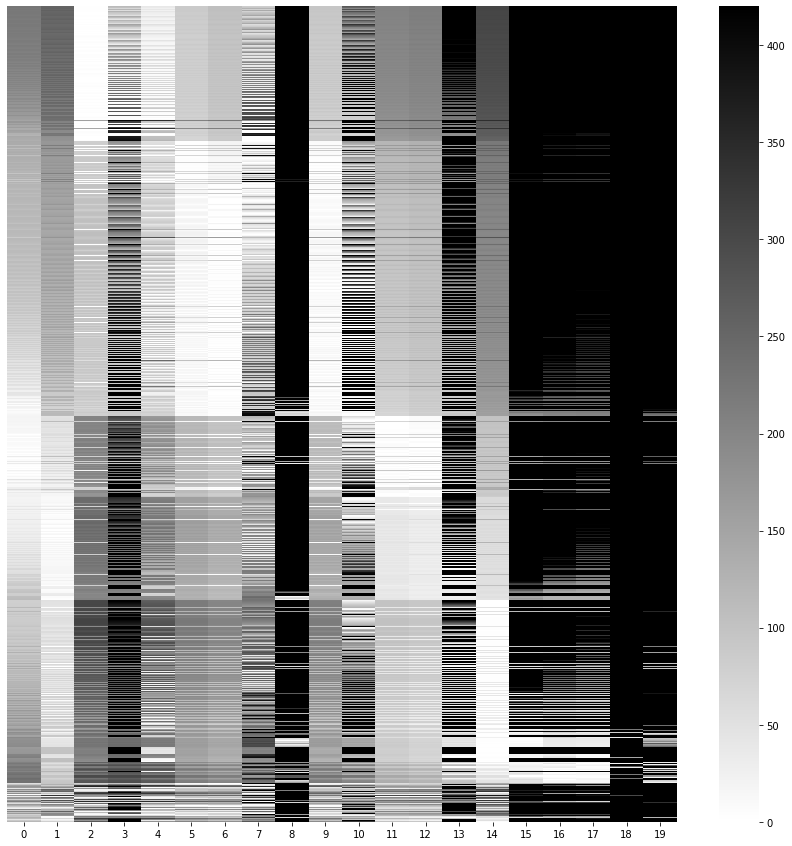

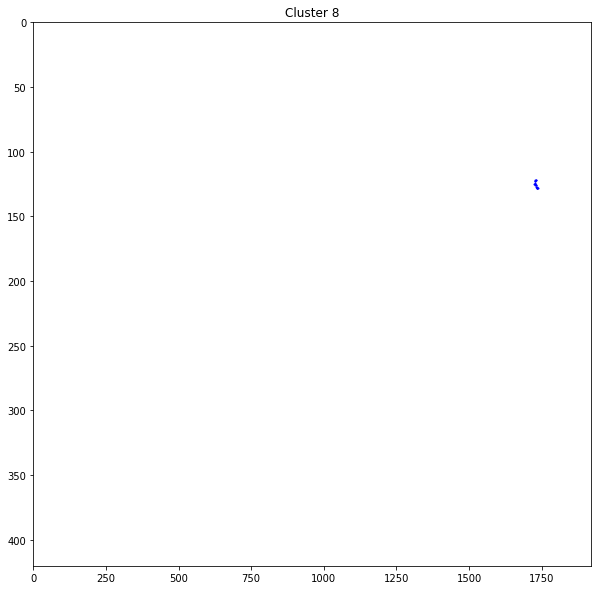

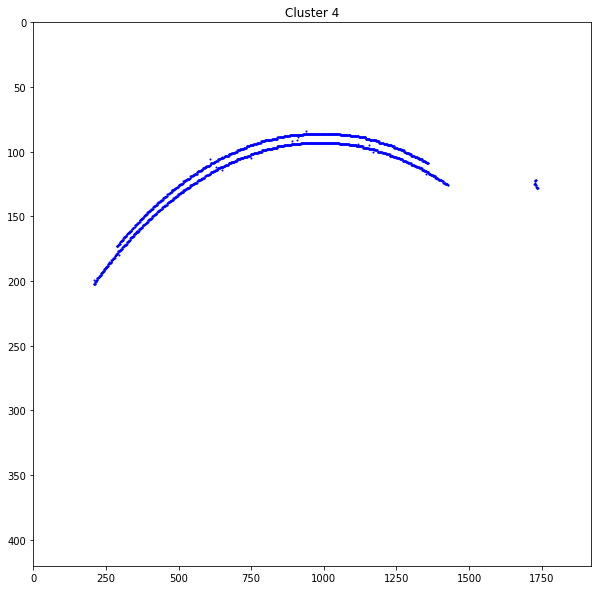

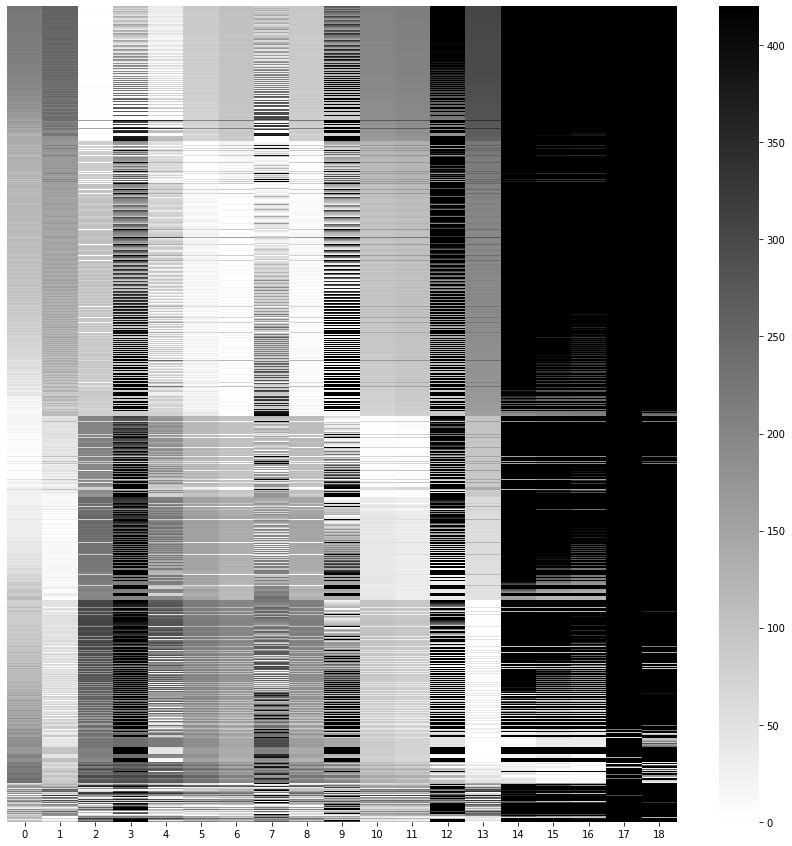

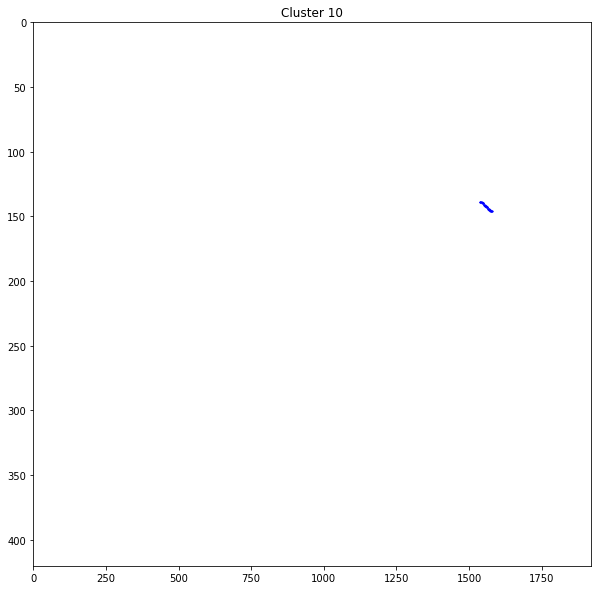

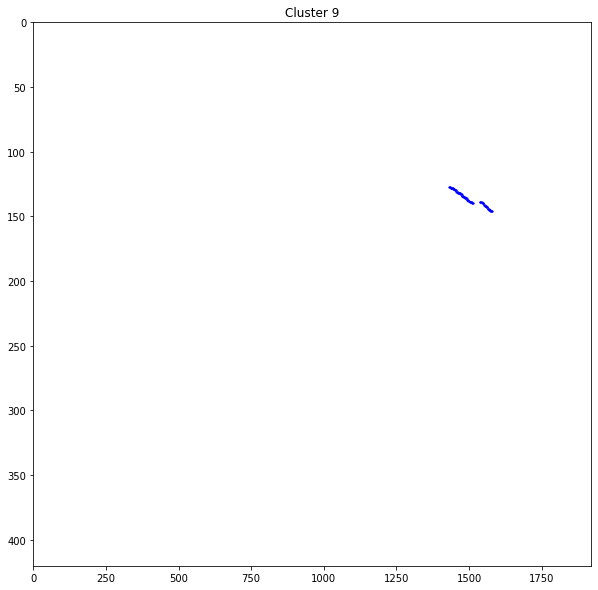

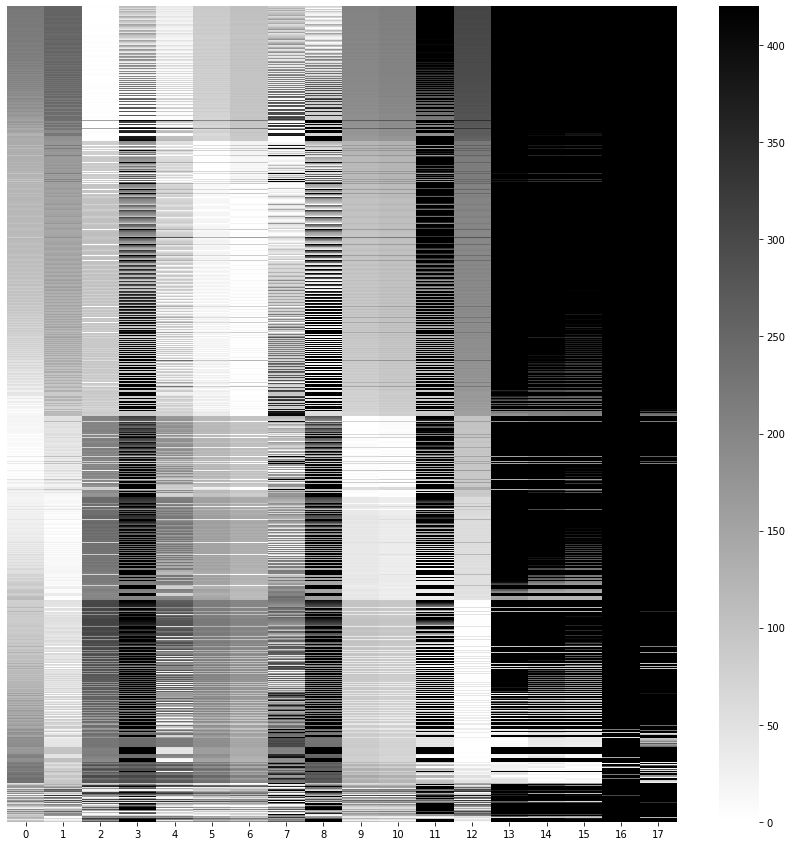

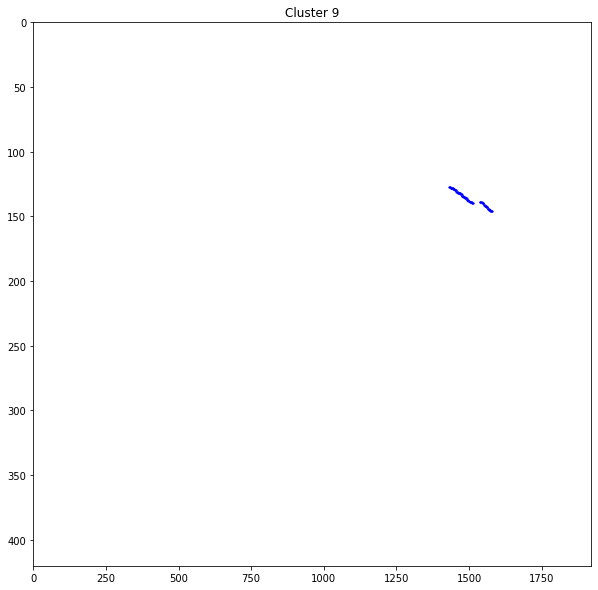

In [127]:
# method
while len(clusters_label)!=10:
    
    # get preference matrix
    matrix = get_preference_matrix (clusters, pts, limit= None, step_debug=1000)

    # truncate preference matrix
    threshold = roi.shape[0]
    matrix[matrix>threshold] = threshold
    print_preference_matrix(matrix)
    
    # calculate similarity matrix
    similarity_matrix = columns_similarity(matrix)

    # get cluster relations based on column similarity matrix
    allClusterRelations = getClusterRelations(similarity_matrix)
    best = bestClusterRelation(allClusterRelations)
    print("simplify cluster {}".format(best))
    print_cluster(clusters[best.cluster_i], pts, best.cluster_i)

    # modifiy the clusters
    clusters, clusters_label = aggregate_cluster(clusters, clusters_label, best)
    print_cluster(clusters[best.cluster_o], pts, best.cluster_o)
